In [5]:
from gfootball.env.scenario_builder import all_scenarios
print(all_scenarios())

['11_vs_11_competition', '11_vs_11_easy_stochastic', '11_vs_11_hard_stochastic', '11_vs_11_kaggle', '11_vs_11_stochastic', '1_vs_1_easy', '5_vs_5', 'academy_3_vs_1_with_keeper', 'academy_corner', 'academy_counterattack_easy', 'academy_counterattack_hard', 'academy_empty_goal', 'academy_empty_goal_close', 'academy_pass_and_shoot_with_keeper', 'academy_run_pass_and_shoot_with_keeper', 'academy_run_to_score', 'academy_run_to_score_with_keeper', 'academy_single_goal_versus_lazy', 'test_example_multiagent', 'tests']


In [1]:
import gym
import numpy as np
from gym.spaces import Box
import gfootball.env as football_env
from gfootball.env import create_environment as _create_env
from gym.wrappers import FrameStack

# Your StackFlattenWrapper from before
class StackFlattenWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        # Env.space is (K, H, W, C)
        K, H, W, C = env.observation_space.shape
        self.K, self.H, self.W, self.C = K, H, W, C
        self.observation_space = Box(0, 255, (K * C, H, W), env.observation_space.dtype)

    def observation(self, obs):
        arr = np.asarray(obs)                     # (H*K, W, C)
        arr = arr.reshape(self.K, self.H, self.W, self.C)  # (K, H, W, C)
        arr = arr.transpose(0, 3, 1, 2)           # (K, C, H, W)
        return arr.reshape(self.K * self.C, self.H, self.W)

# Monkey‑patch create_environment
def create_environment(env_name: str,
                       representation: str = 'raw',
                       **kwargs):
    if representation == 'stacked_extracted':
        # 1) Get the 4‑plane extracted SMM
        env = _create_env(env_name,
                          representation='extracted',
                          **kwargs)
        # 2) Stack 4 frames
        env = FrameStack(env, 4)
        # 3) Flatten to (16,72,96)
        env = StackFlattenWrapper(env)
        return env
    else:
        # fallback to the original
        return _create_env(env_name,
                           representation=representation,
                           **kwargs)

# Override in the module
football_env.create_environment = create_environment

In [29]:
env = football_env.create_environment(
    env_name='academy_empty_goal_close',
    representation='stacked_extracted',
    number_of_left_players_agent_controls=1,
    rewards ='scoring,checkpoints,ball_ownership,goals_diff,pass,shot,direction,move_to_ball',
    render=False
)
print(env.observation_space.shape)  # -> (16, 72, 96)
print(env.action_space)  # -> Discrete(19)
print(env.reward_range)

(16, 72, 96)
Discrete(19)
(-inf, inf)


In [30]:

obs = env.reset()
done = False
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    print(f"\nTotal reward: {reward:.3f}")
    for k, v in info.items():
        if "reward" in k:
            print(f"{k}: {v:.3f}")



Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.900
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0

(16, 72, 96)


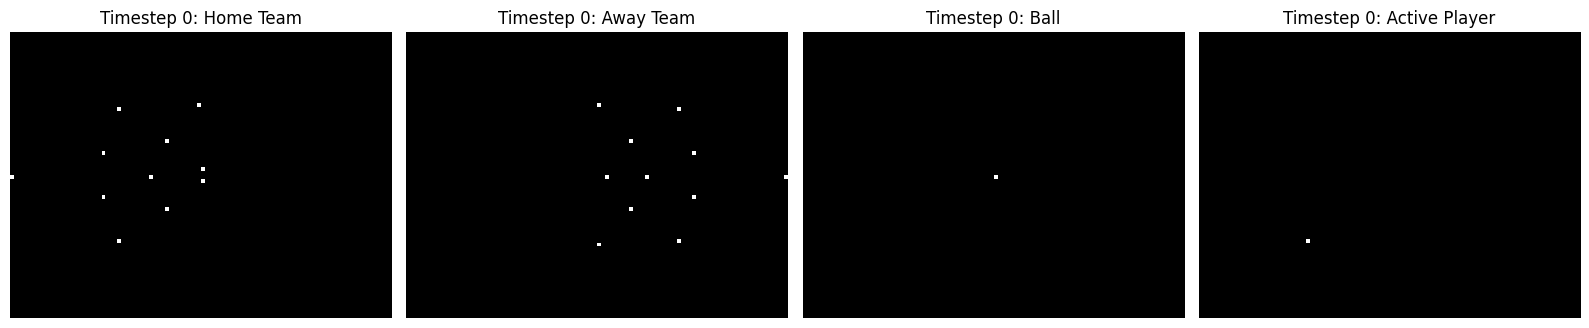

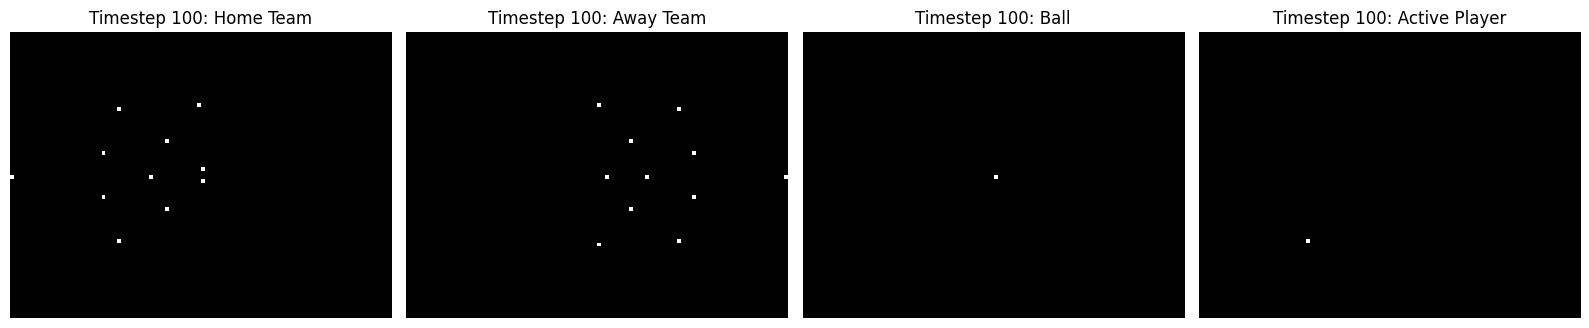

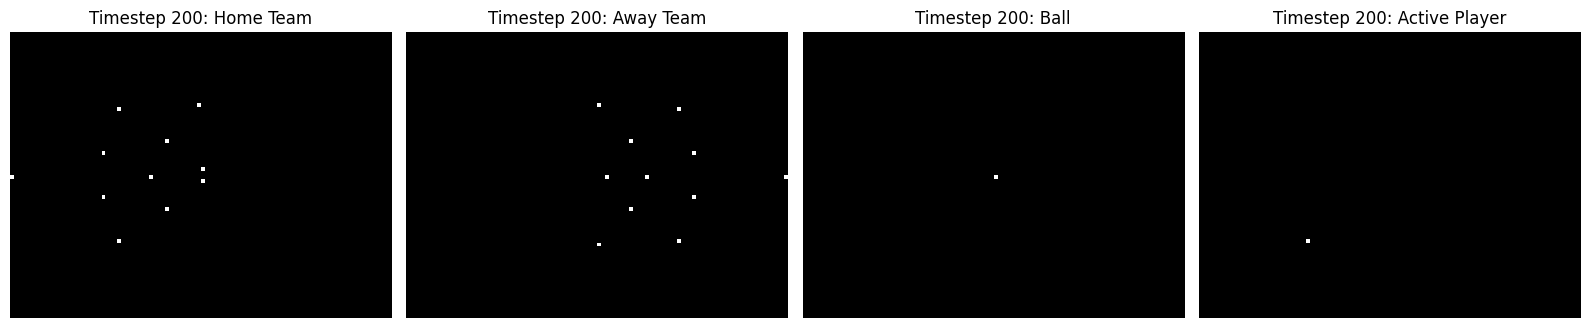

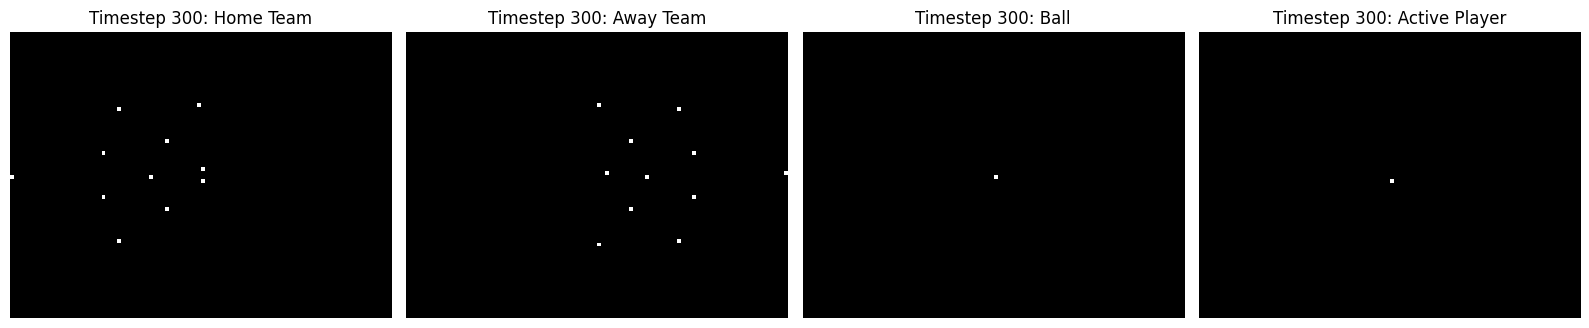

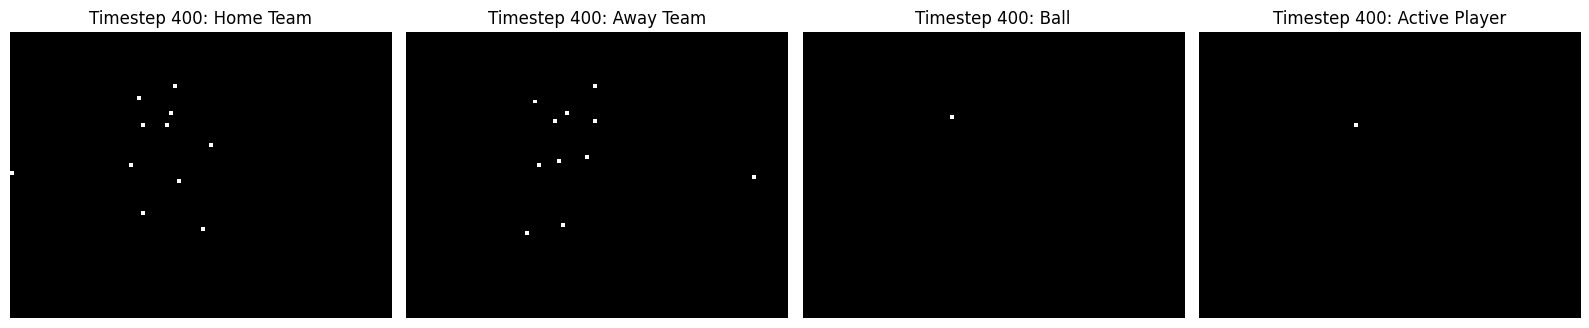

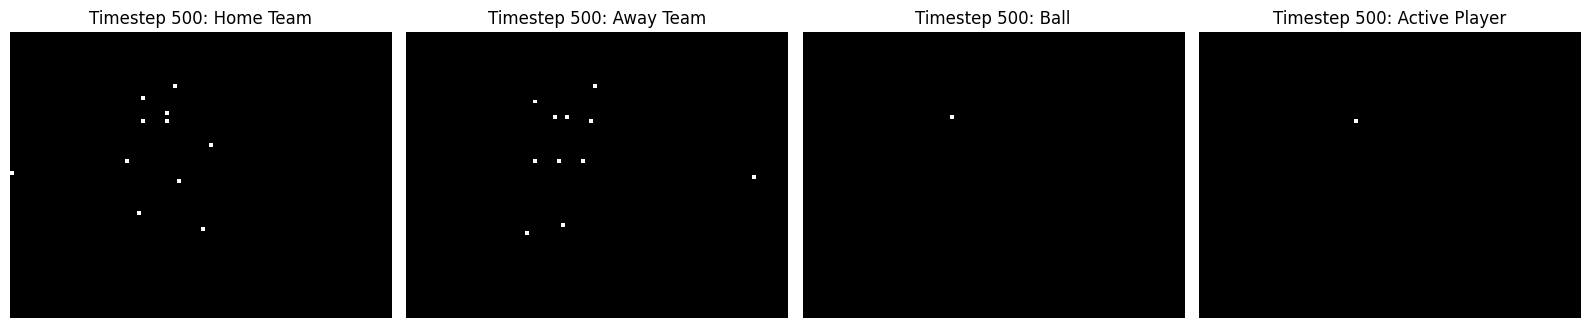

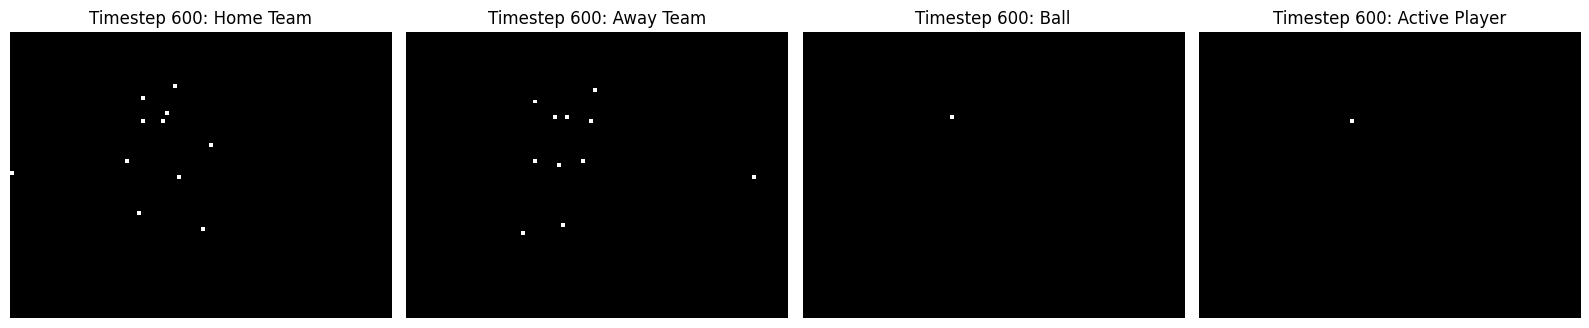

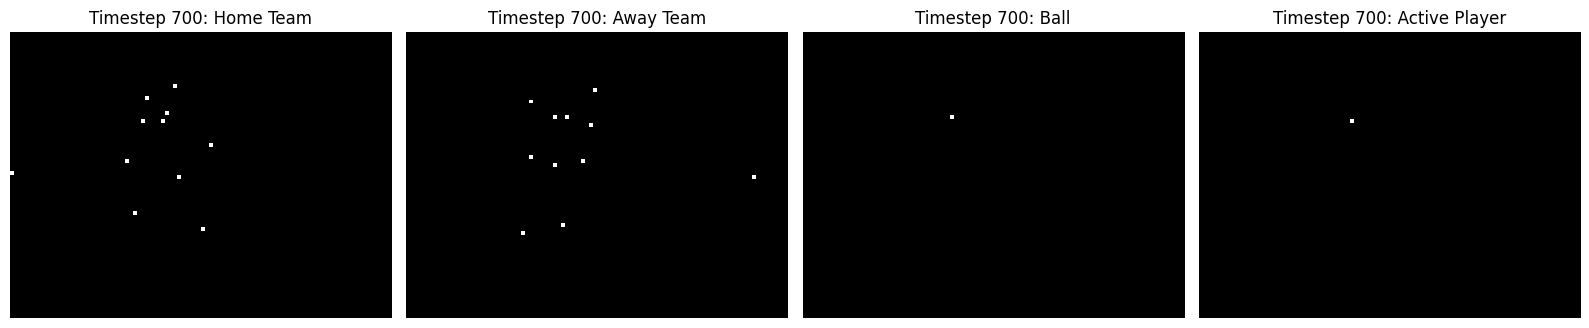

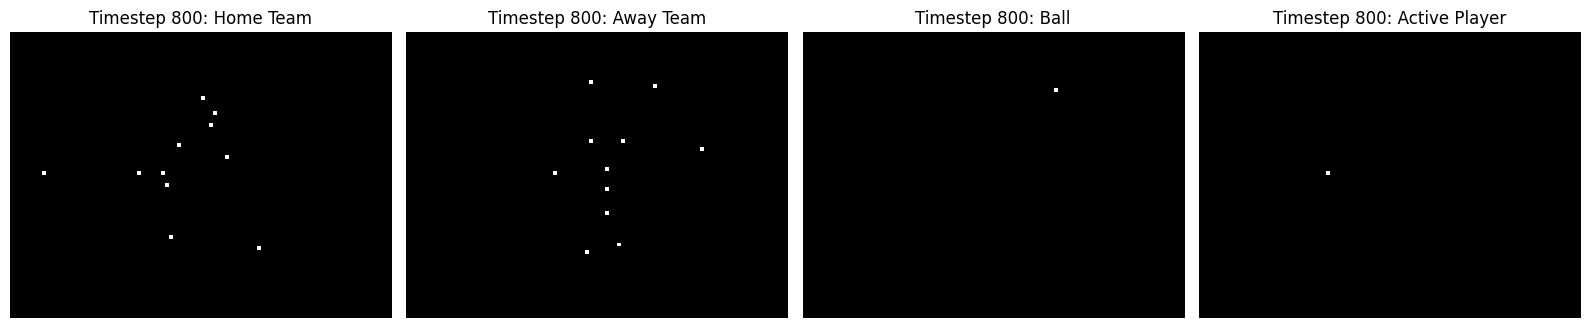

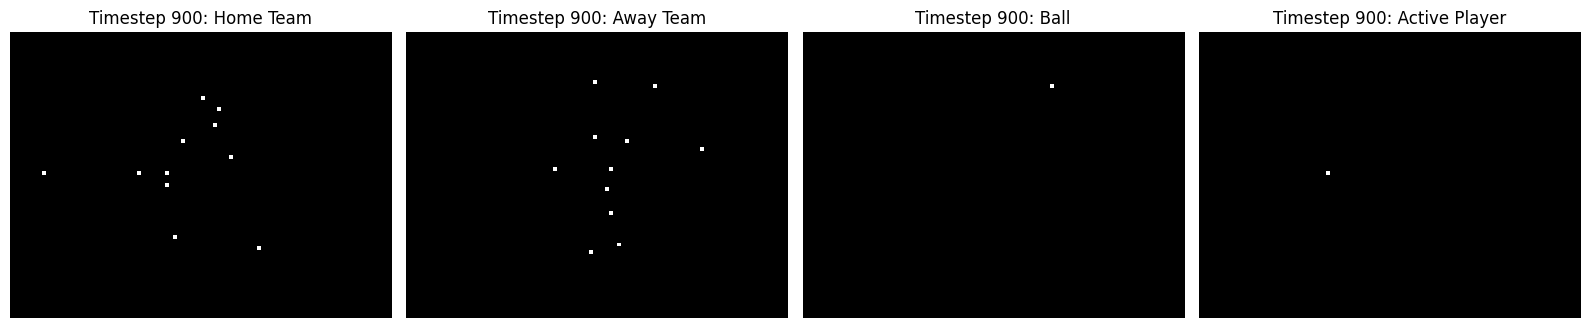

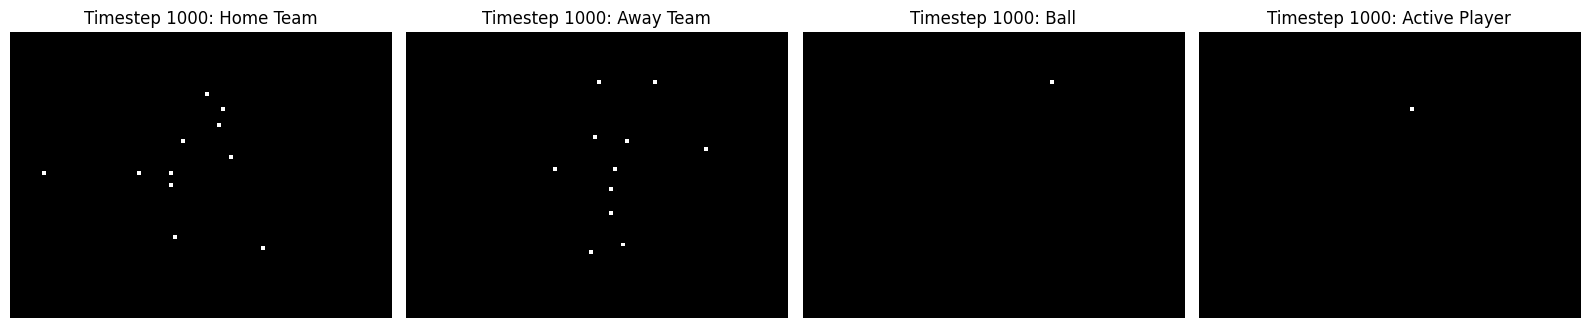

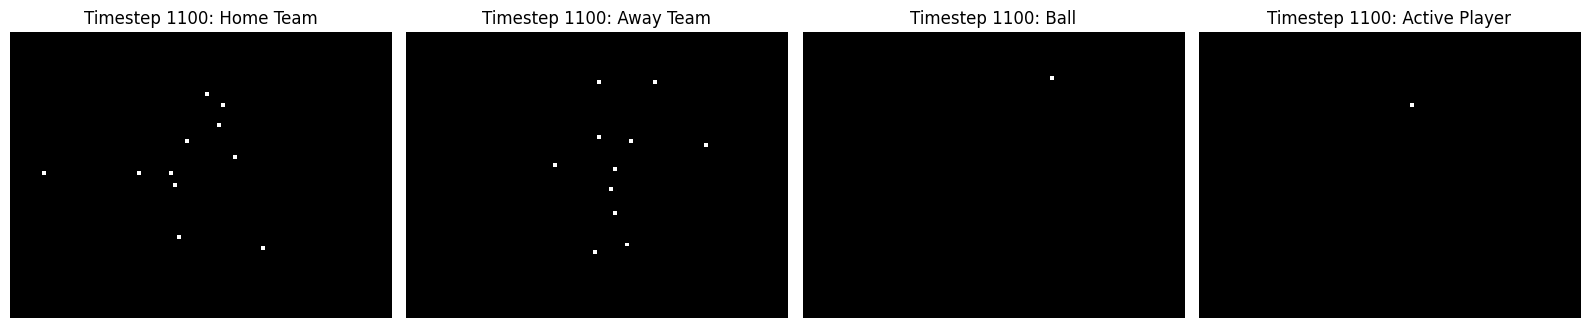

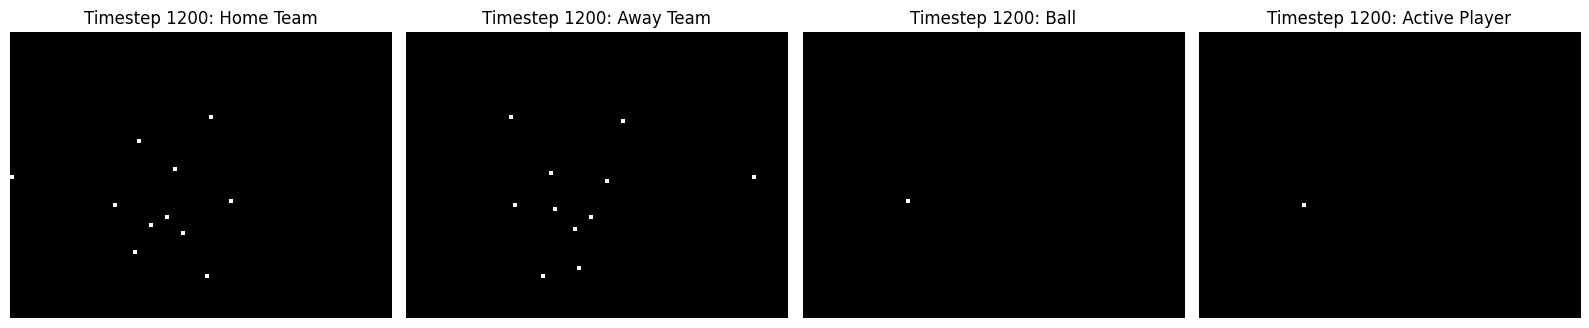

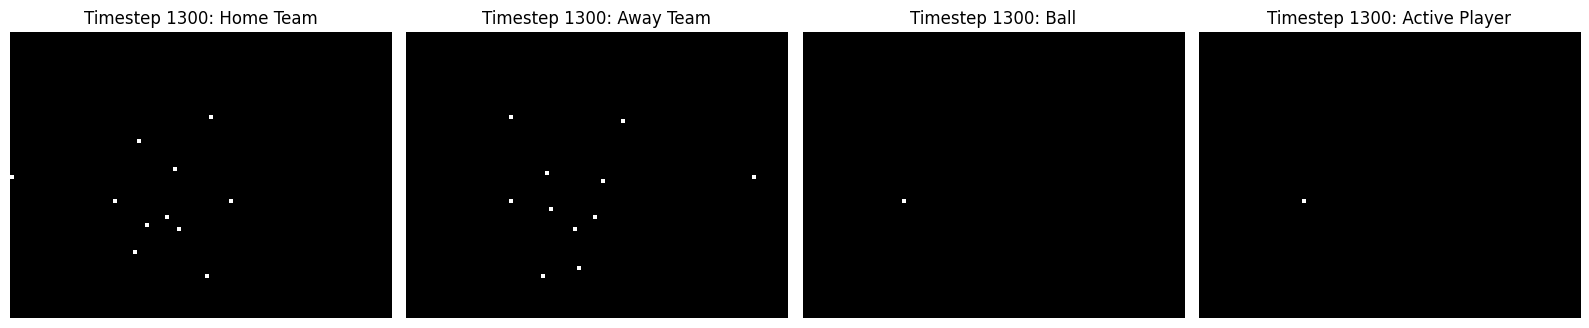

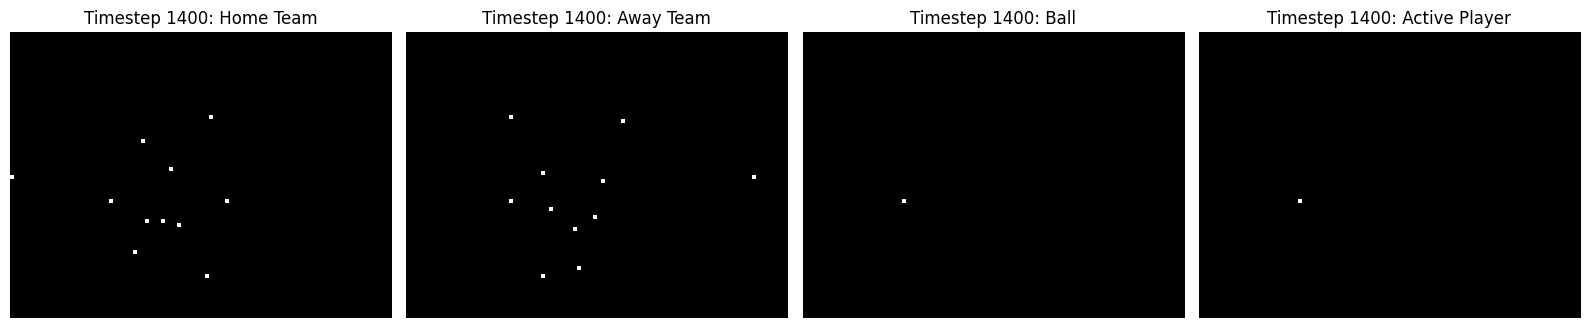

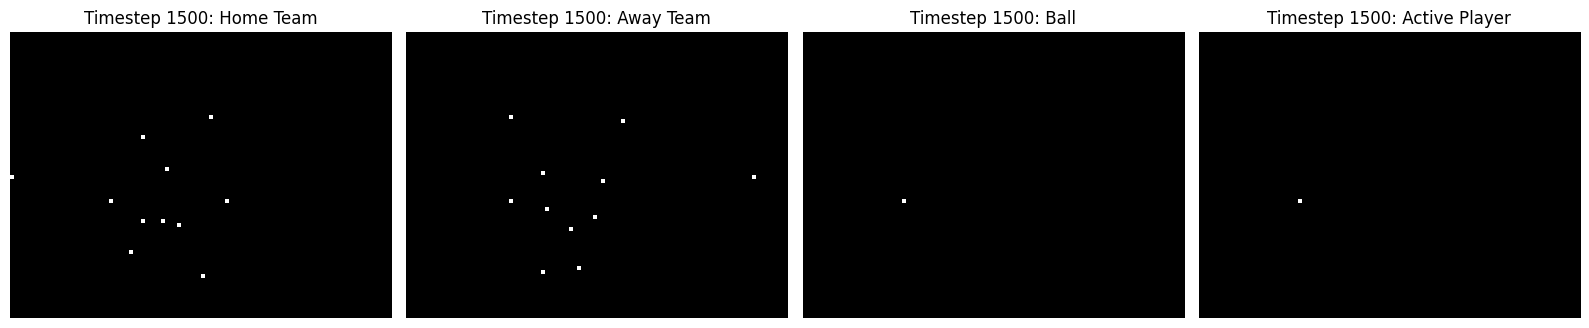

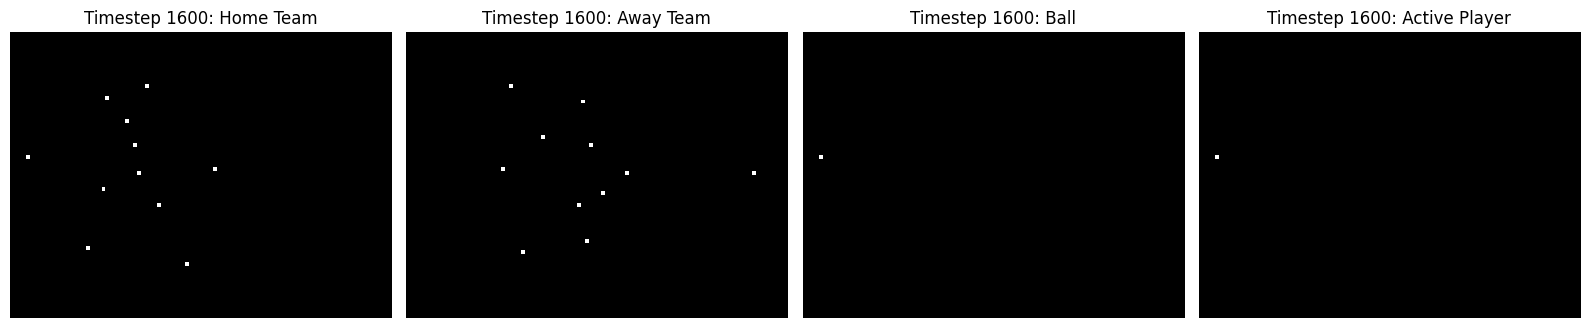

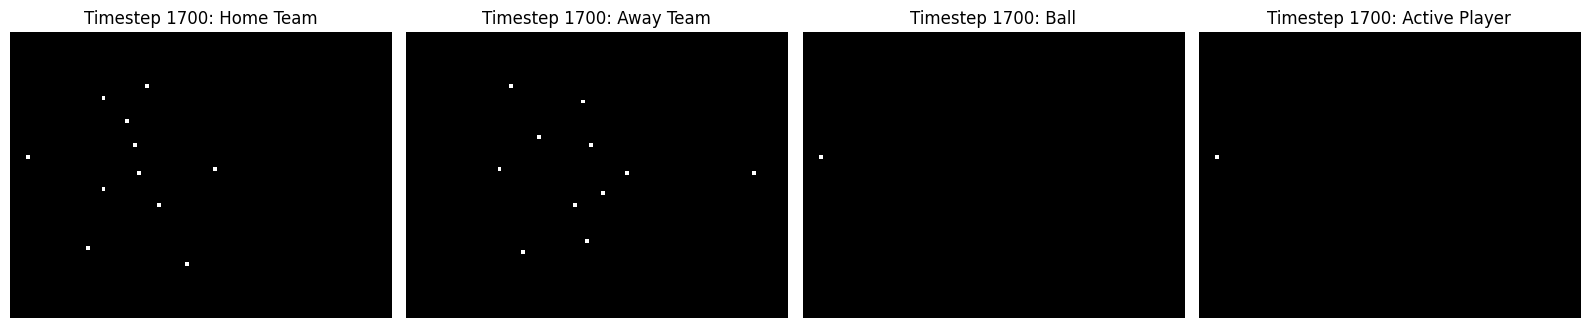

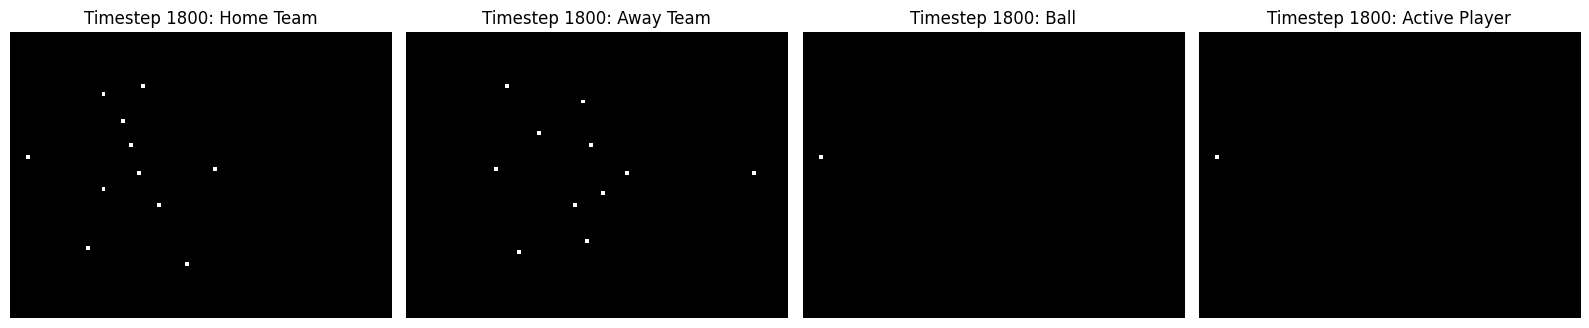

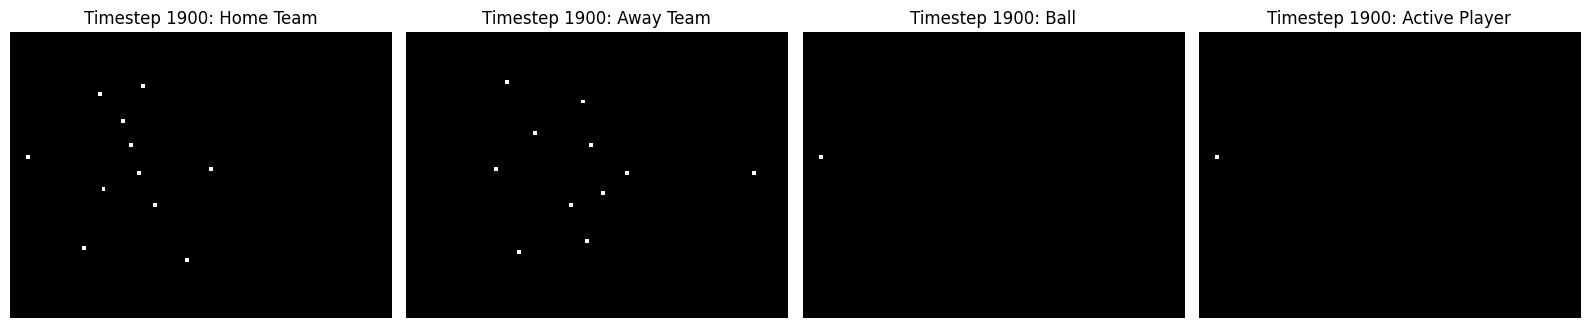

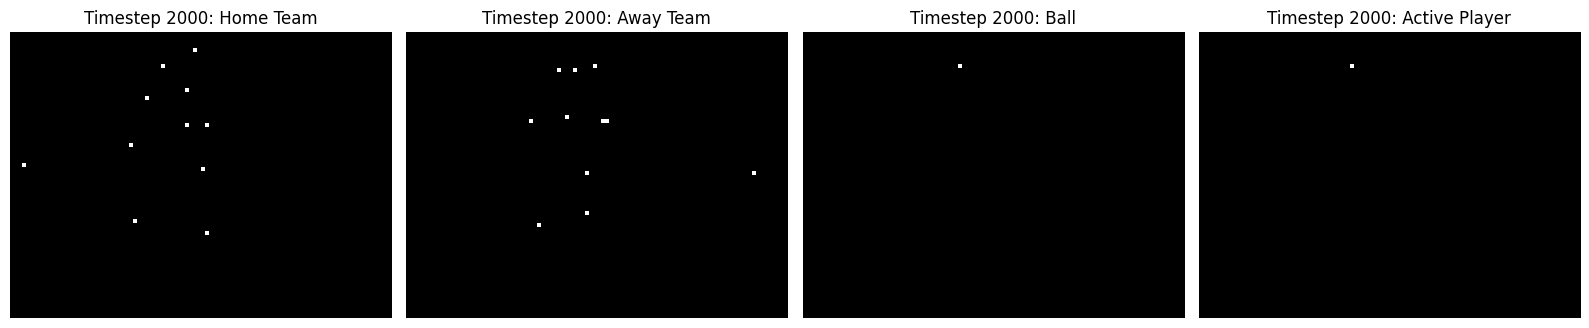

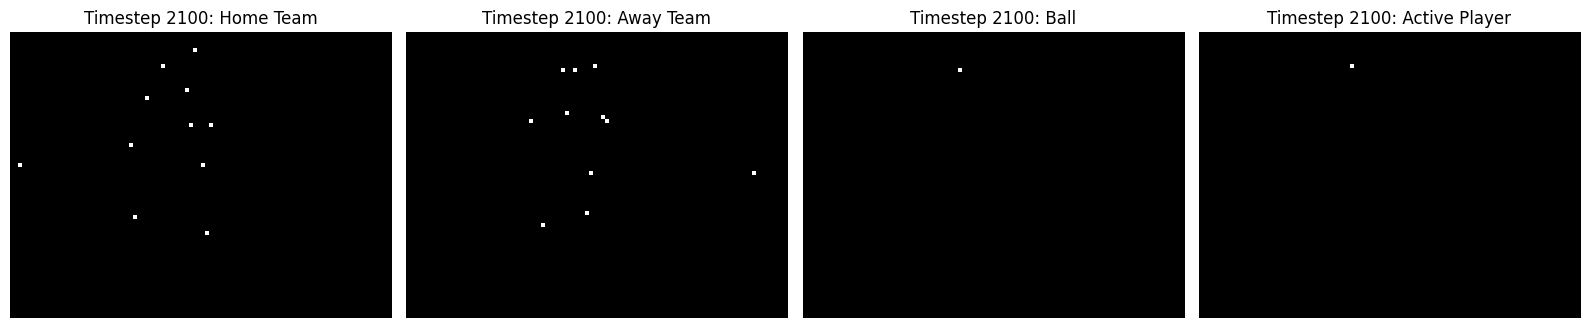

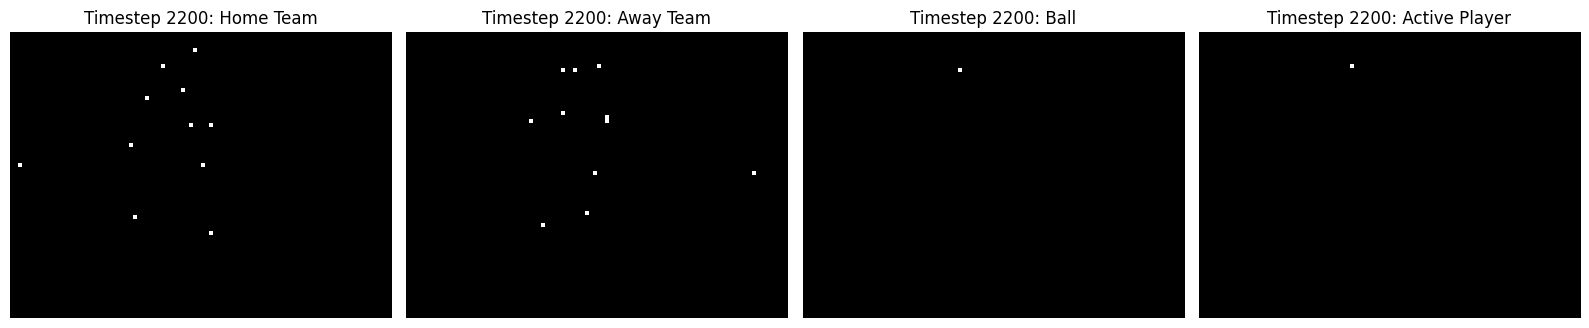

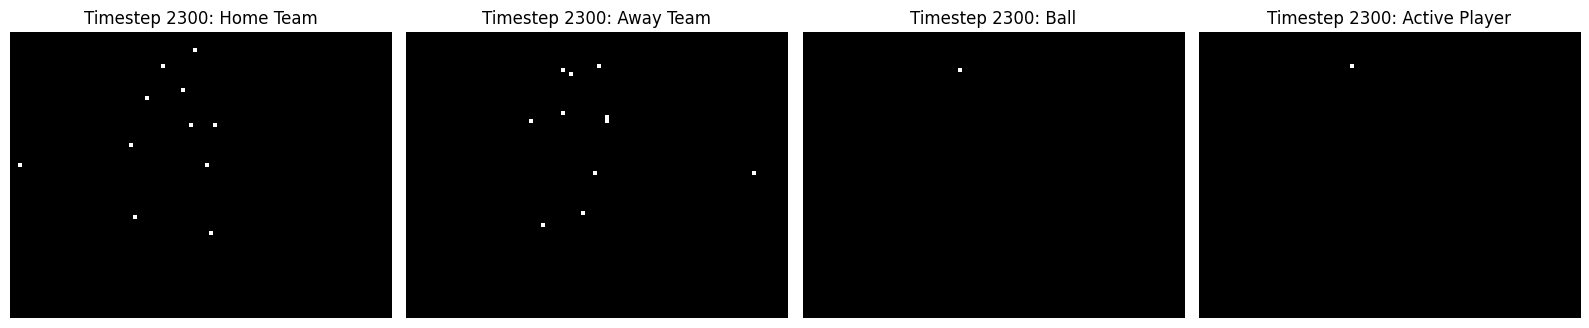

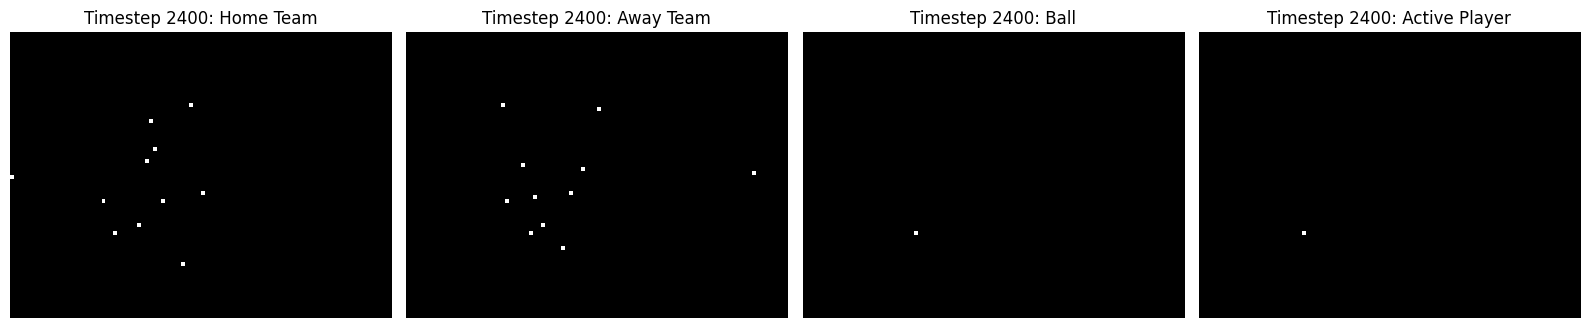

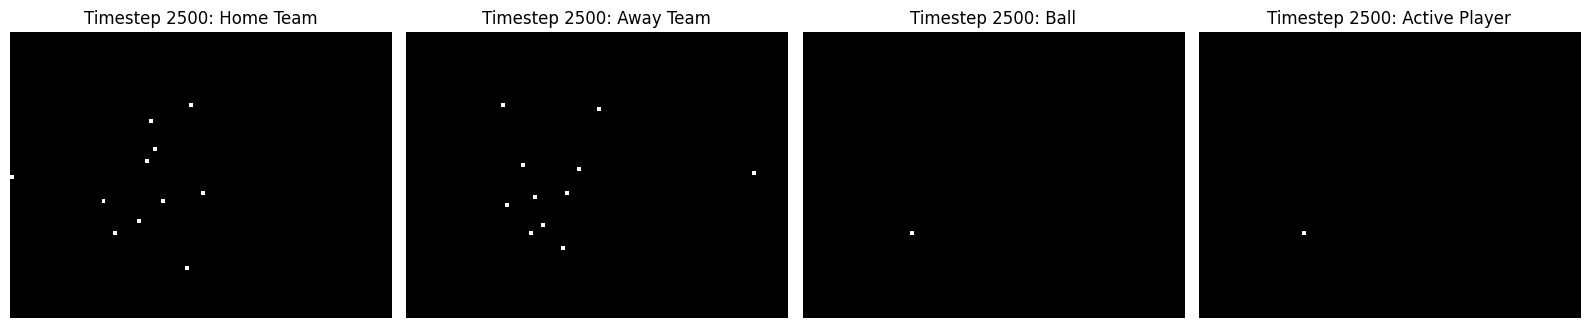

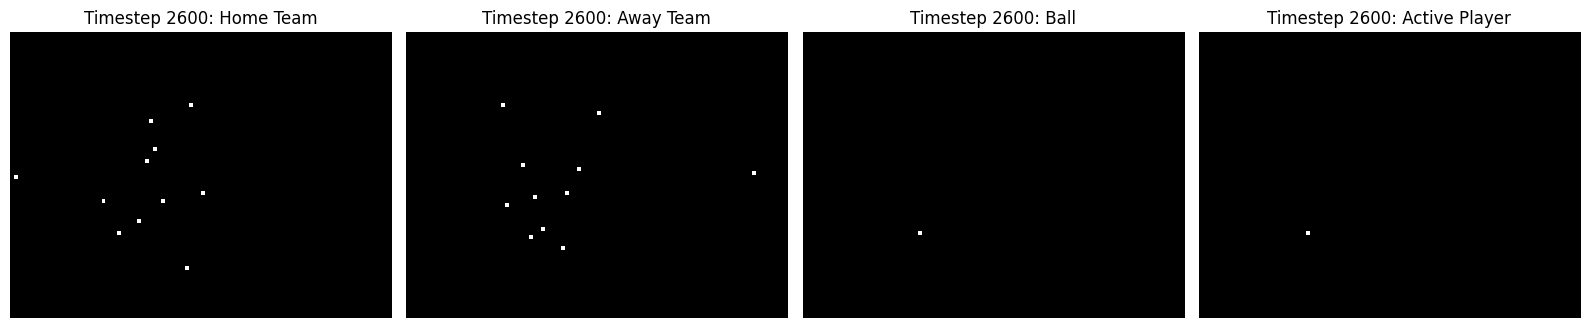

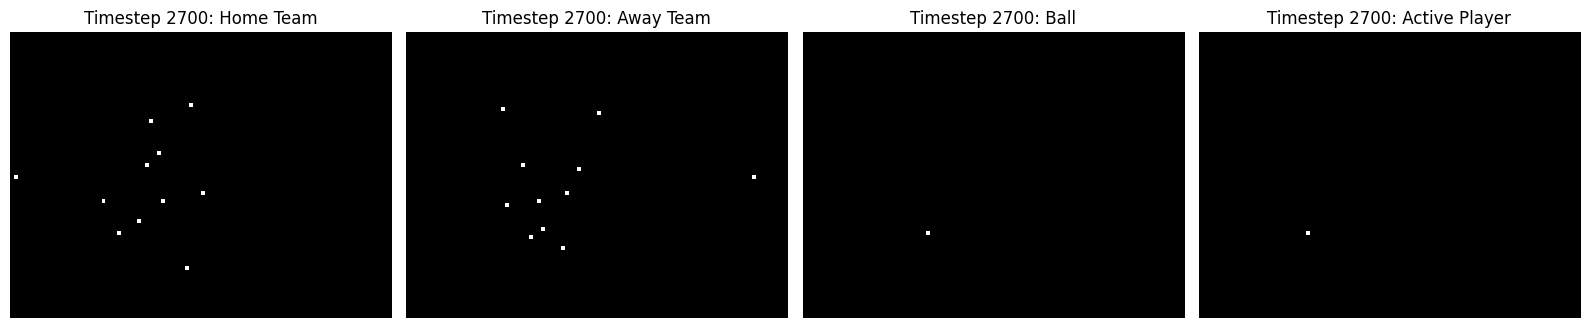

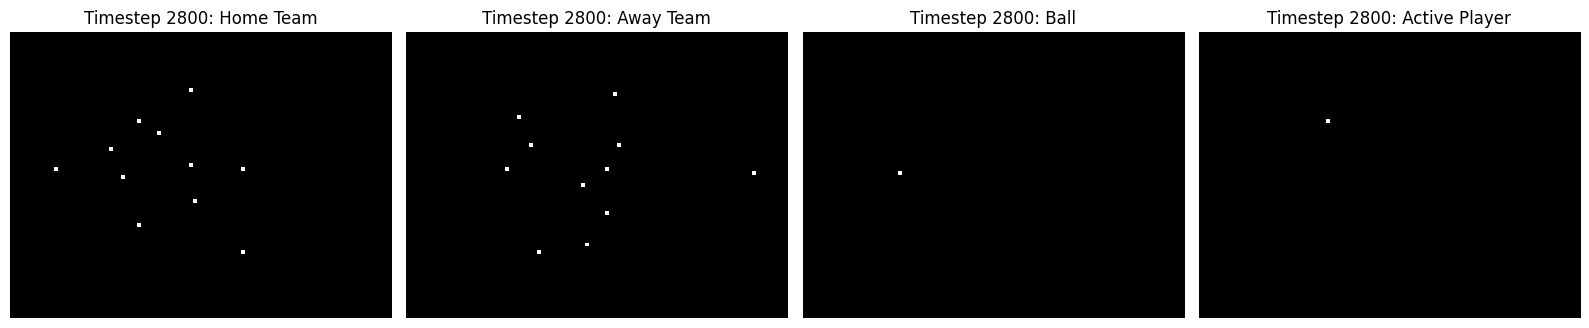

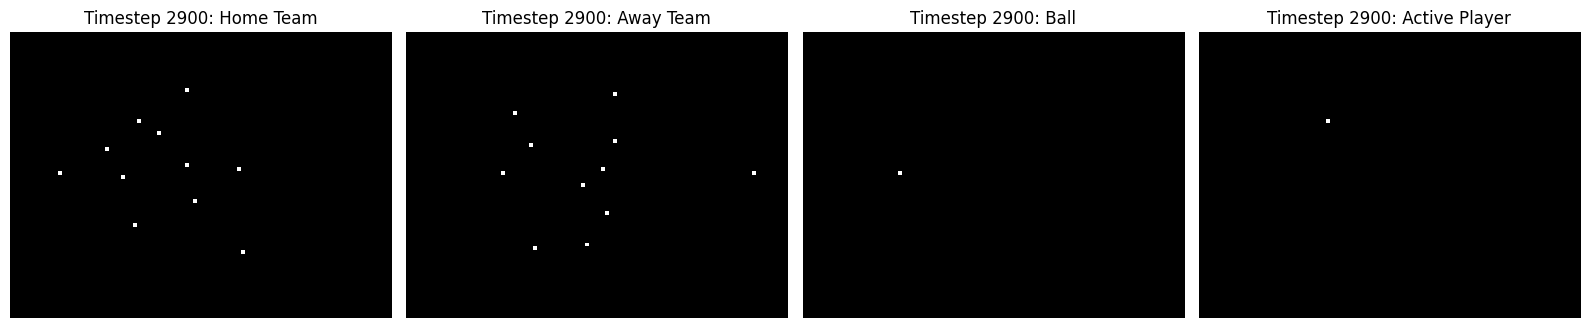

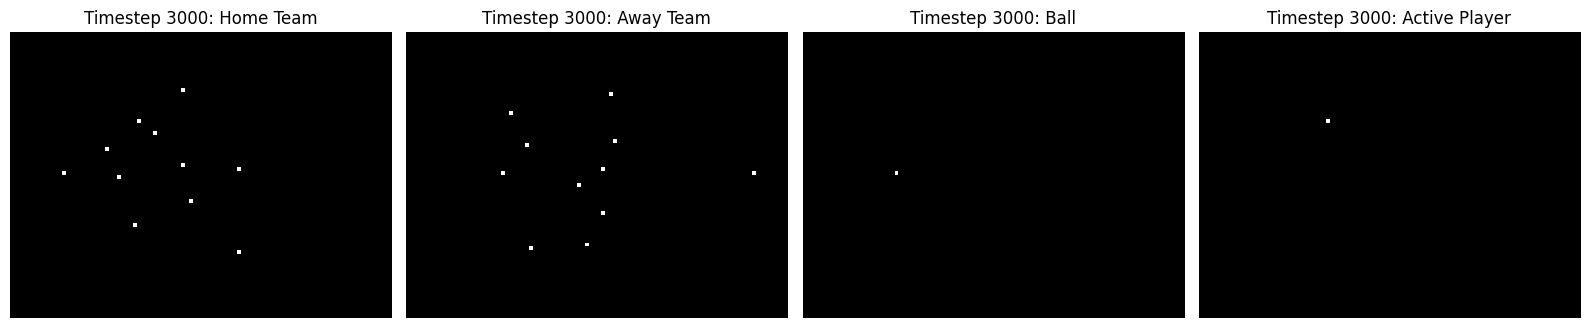

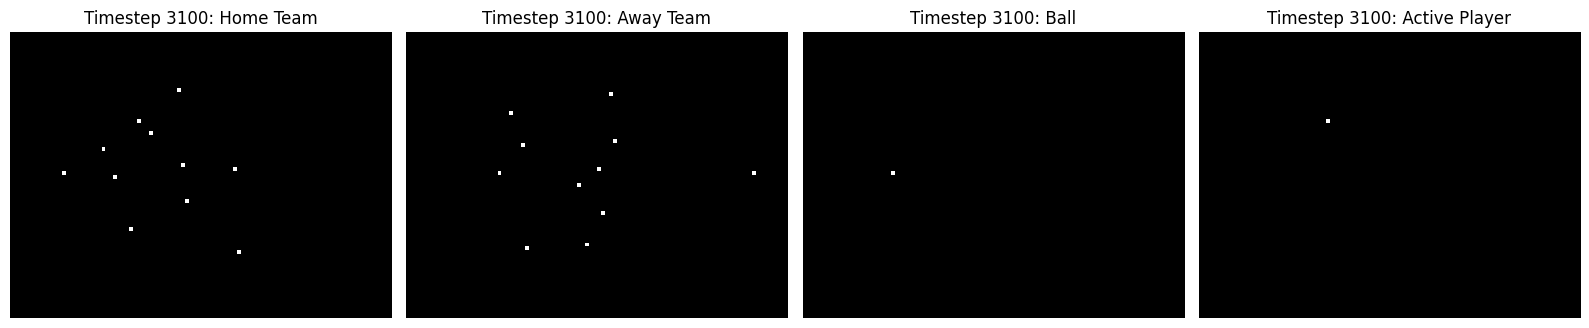

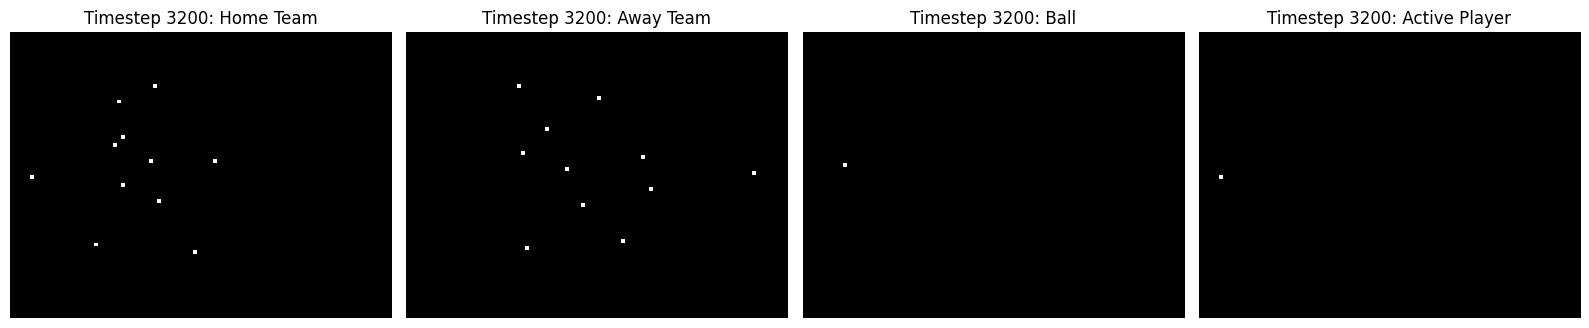

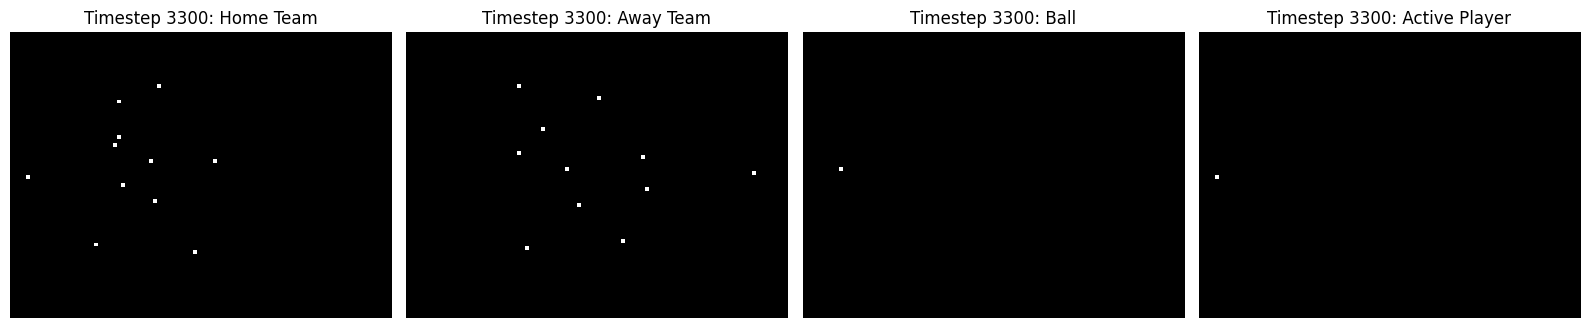

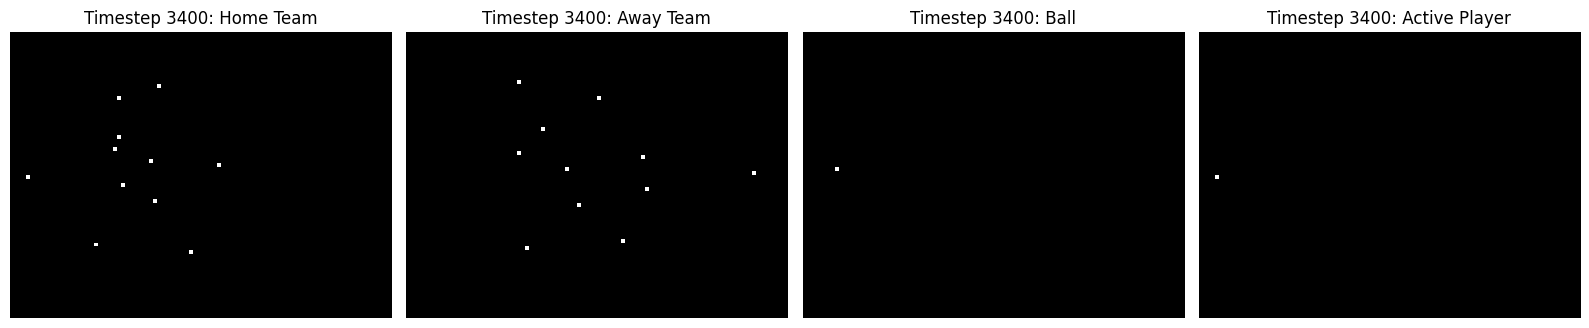

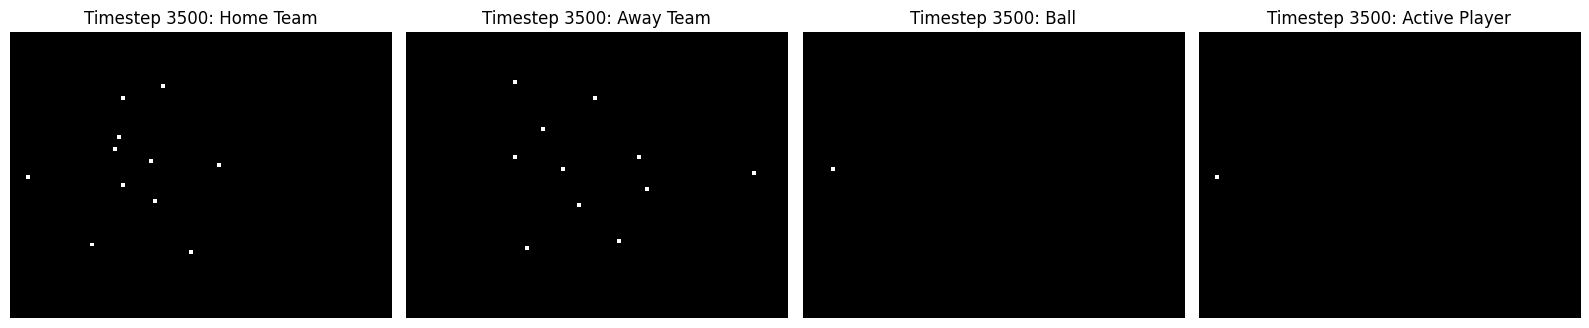

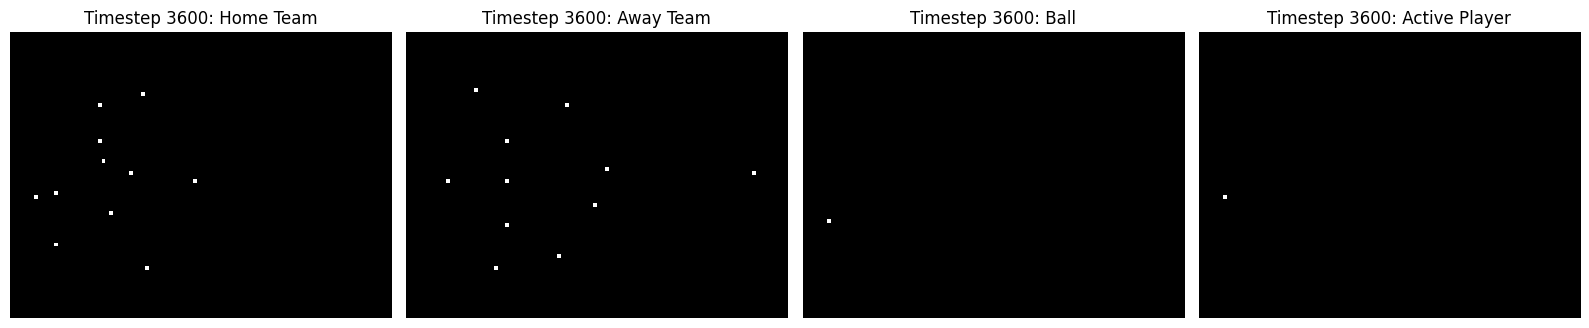

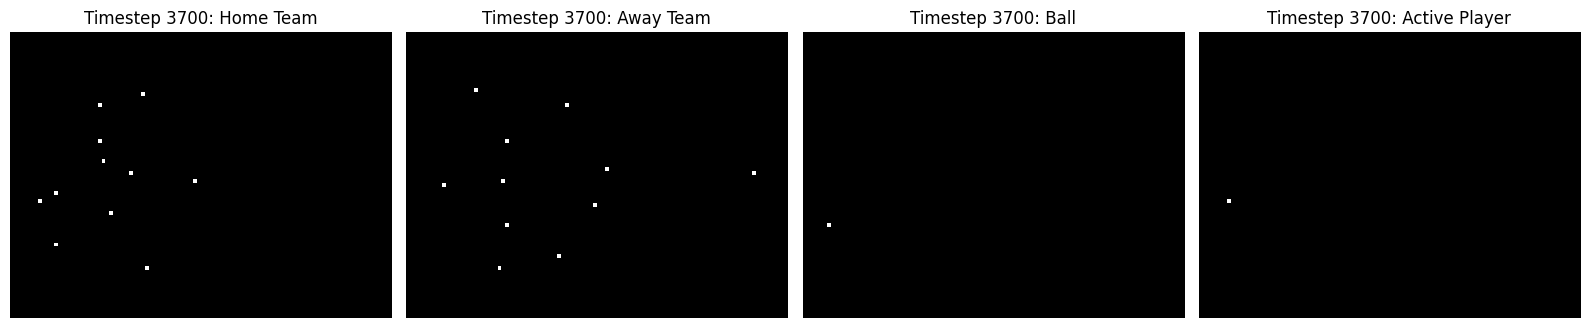

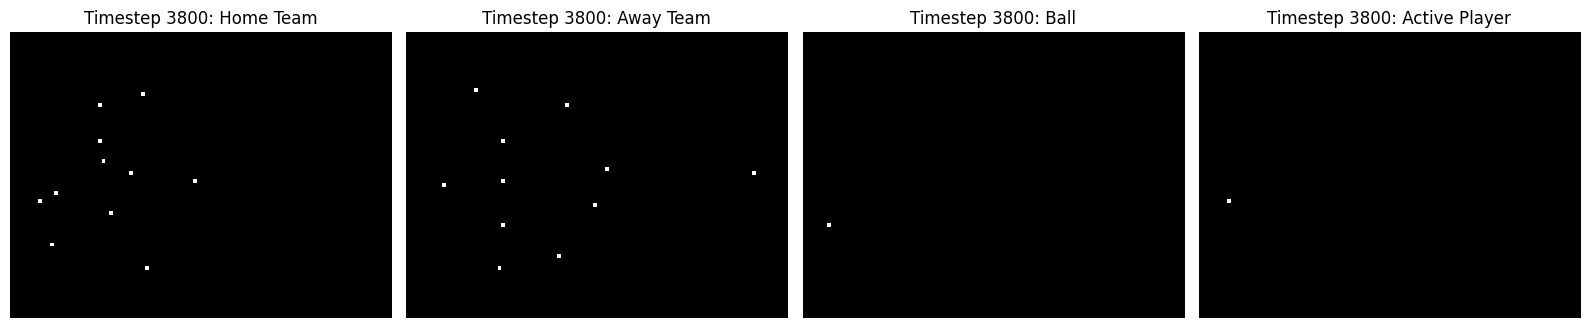

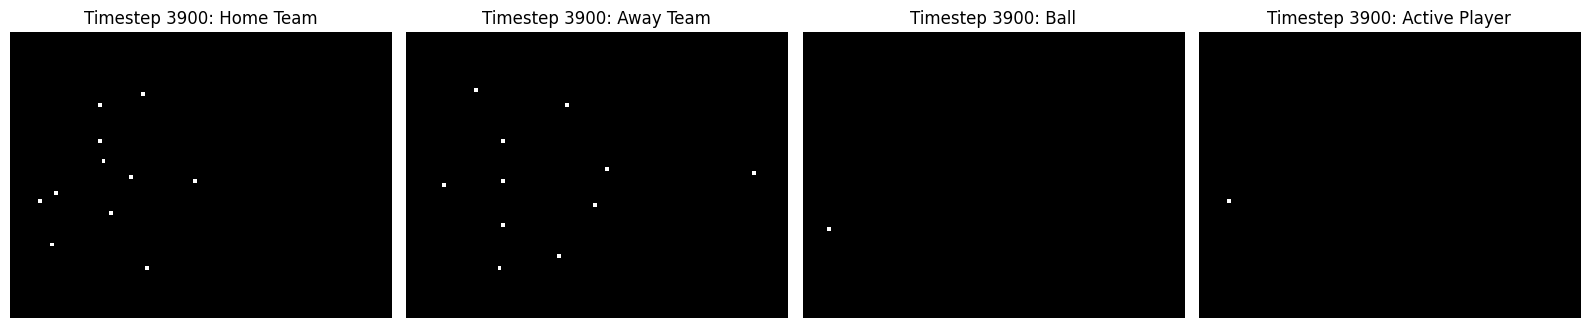

In [41]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gfootball.env import create_environment

# 1) Create the SMM “extracted” environment
env = create_environment(
    env_name='11_vs_11_stochastic',
    representation='stacked_extracted',             # 4 minimap planes
    number_of_left_players_agent_controls=1,
    render=False
)

# 2) Reset and collect the first frame (t=0)
frames = []
print(obs.shape) # obs.shape == (16, 72, 96)
obs = env.reset() 

# 3) Step and collect every 10th stacked frame
for step in range(1000):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if step % 100 == 0:
    # reshape from (16,72,96) → (stack=4, channels=4, H=72, W=96)
        obs4 = obs.reshape(4, 4, 72, 96)
    
        # iterate over the 4 stacked frames
        for k in range(obs4.shape[0]):
        # obs4[k] has shape (4,72,96): (channels, H, W)
        # transpose to (H, W, channels)
            img = np.transpose(obs4[k], (1, 2, 0))  # now (72,96,4)
            frames.append(img)
    
    if done:
        break
# 4) Visualize
plane_names = ['Home Team', 'Away Team', 'Ball', 'Active Player']

for t, frame in enumerate(frames):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    for i, ax in enumerate(axes):
        ax.imshow(frame[:, :, i], cmap='gray', vmin=0, vmax=1)
        ax.set_title(f'Timestep {t*1000}: {plane_names[i]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
from gfootball.env import football_action_set

# Provide a proper config dictionary
config = {"action_set": "default"}
action_set = football_action_set.get_action_set(config)

print("Number of actions:", len(action_set))
for i, action in enumerate(action_set):
    print(f"{i}: {action}")


Number of actions: 19
0: idle
1: left
2: top_left
3: top
4: top_right
5: right
6: bottom_right
7: bottom
8: bottom_left
9: long_pass
10: high_pass
11: short_pass
12: shot
13: sprint
14: release_direction
15: release_sprint
16: sliding
17: dribble
18: release_dribble


In [8]:
# Step 1: Reset the environment — this will fill the frame stack
obs = env.reset()

# Step 2: Take a random step
for i in range(2):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    print(action, obs, reward, done, info)
 

2 [[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]] 0.0 False {'score_reward': 0}
12 [[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  .

In [25]:
from gfootball.env import create_environment

env = create_environment(
    env_name='academy_empty_goal_close',
    representation='simple115v2',  # use a simple, fast representation
    number_of_left_players_agent_controls=1,
    rewards='scoring,checkpoints',  # keep it minimal first
    render=False
)

obs = env.reset()
done = False

while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)

    print(f"\nTotal reward: {reward:.3f}")
    for k, v in info.items():
        if "reward" in k:
            print(f"{k}: {v:.3f}")


Total reward: 0.000
score_reward: 0.000

Total reward: 0.900
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 0.000
score_reward: 0.000

Total reward: 1.100
score_reward: 1.000


# gfootball implemented stacked

In [42]:
env = football_env.create_environment(
    env_name='11_vs_11_stochastic',
    representation='extracted',
    stacked=True,
    number_of_left_players_agent_controls=1,
    render=False
)
print(env.observation_space.shape)  # -> (72, 96, 16)


(72, 96, 16)


action count: 0
action count: 1
action count: 2
action count: 3
action count: 4
action count: 5
action count: 6
action count: 7
action count: 8
action count: 9
action count: 10
action count: 11
action count: 12
action count: 13
action count: 14
action count: 15
action count: 16
action count: 17
action count: 18
action count: 19
action count: 20
action count: 21
action count: 22
action count: 23
action count: 24
action count: 25
action count: 26
action count: 27
action count: 28
action count: 29
action count: 30
action count: 31
action count: 32
action count: 33
action count: 34
action count: 35
action count: 36
action count: 37
action count: 38
action count: 39
action count: 40
action count: 41
action count: 42
action count: 43
action count: 44
action count: 45
action count: 46
action count: 47
action count: 48
action count: 49
action count: 50
action count: 51
action count: 52
action count: 53
action count: 54
action count: 55
action count: 56
action count: 57
action count: 58
action 

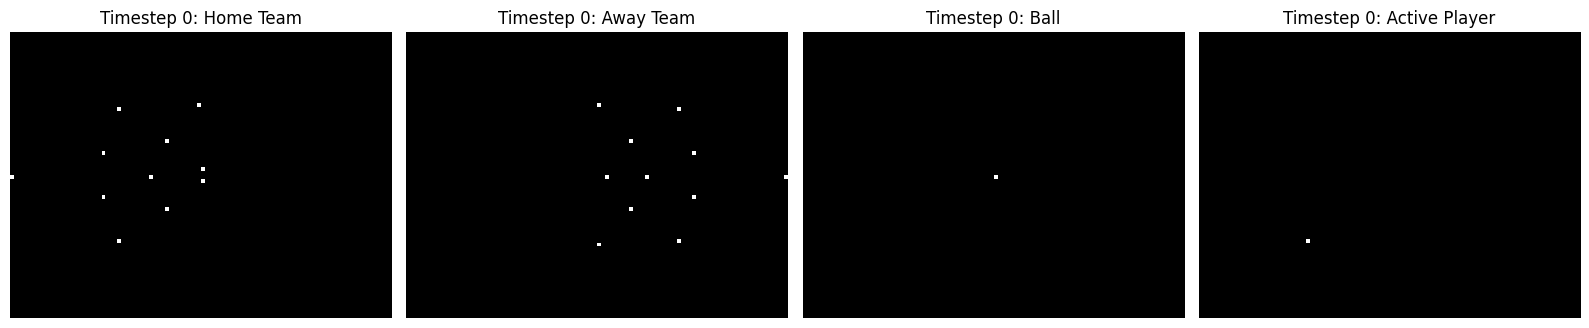

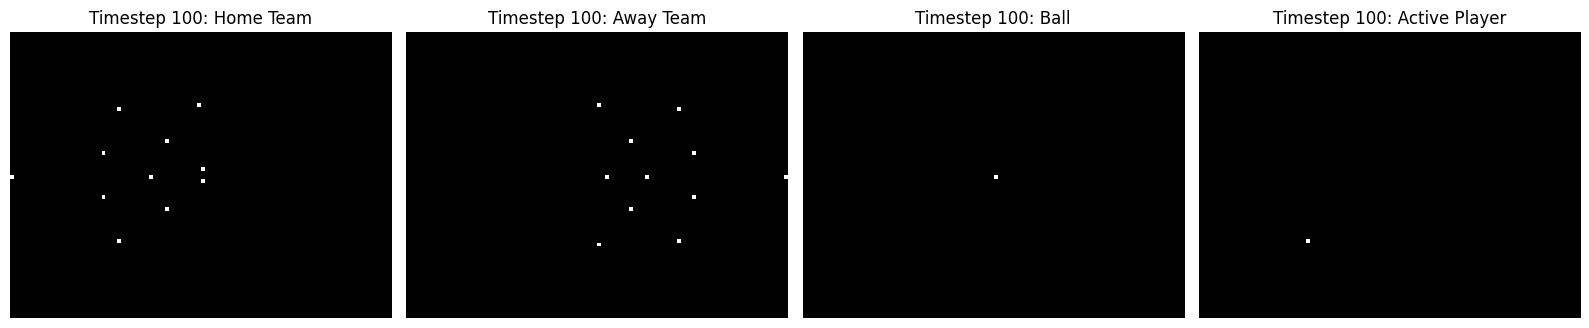

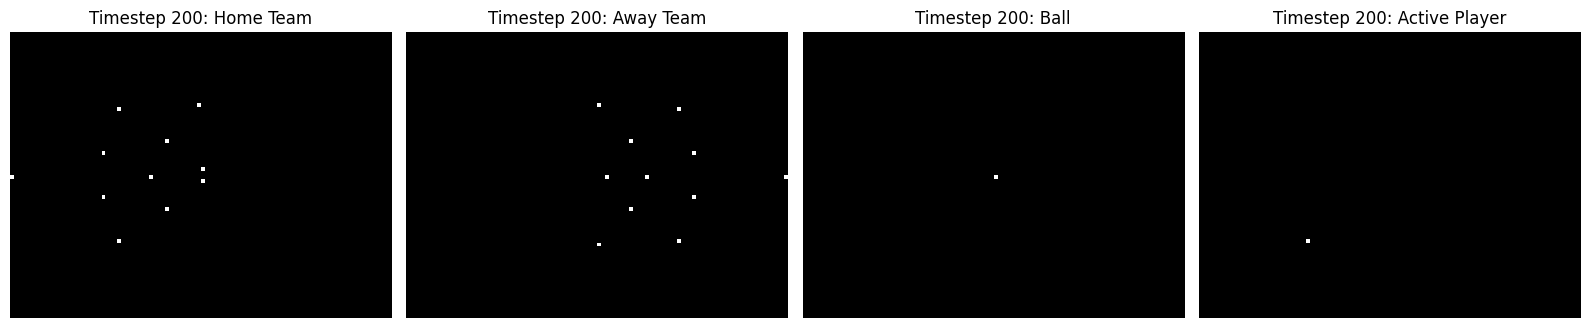

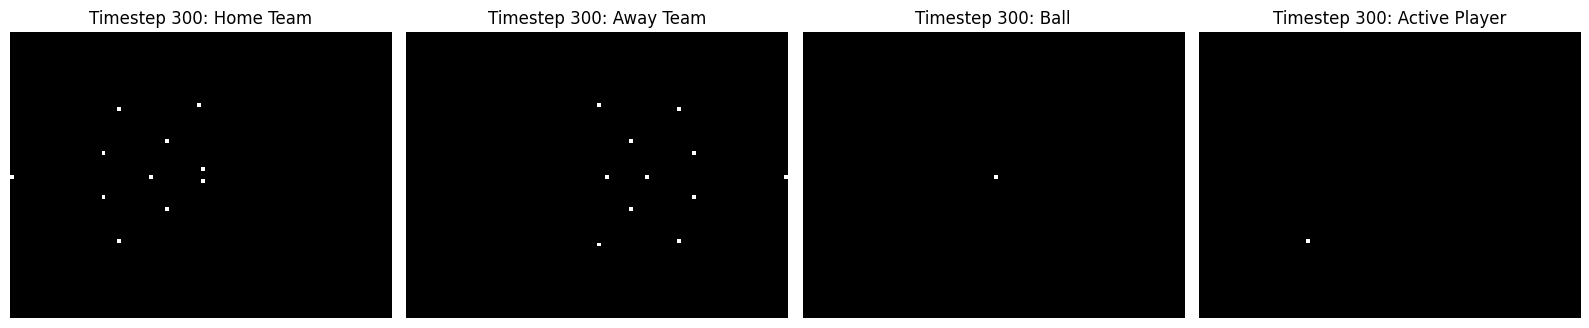

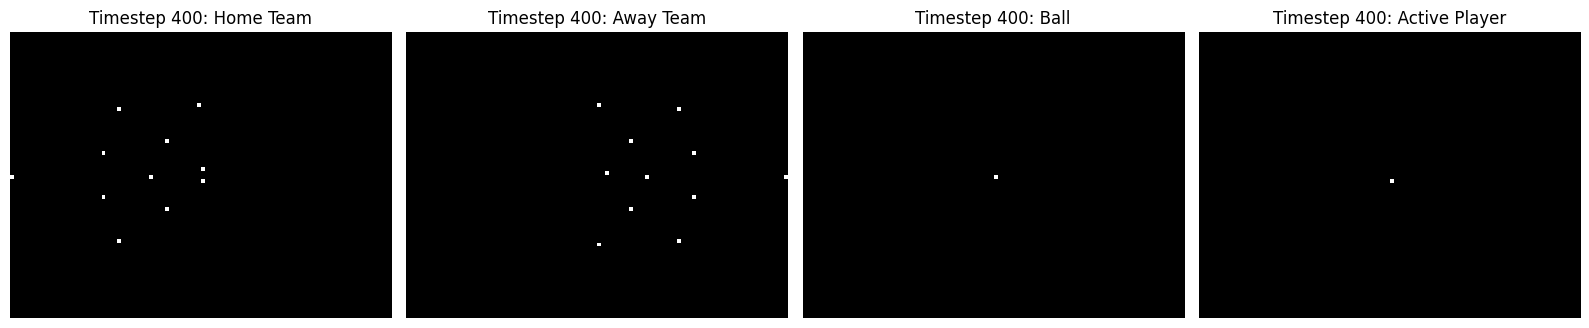

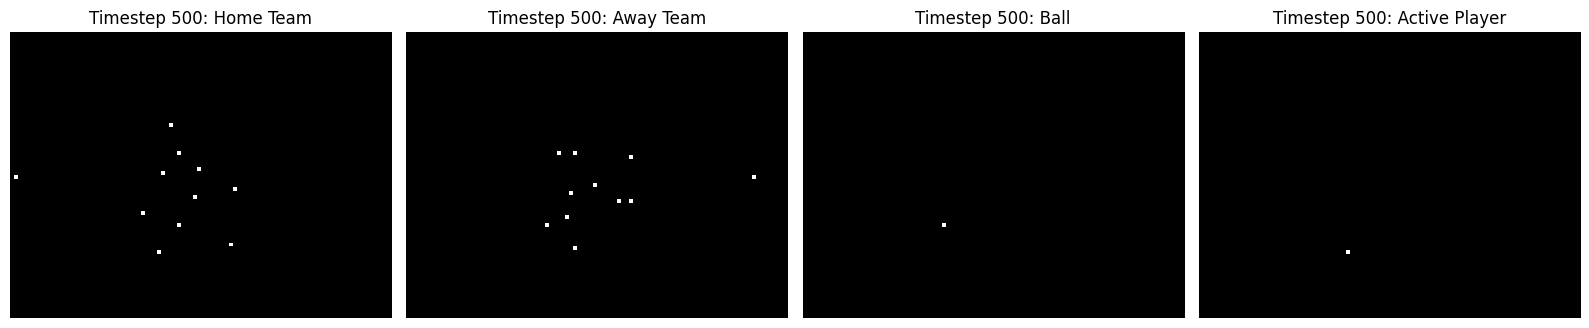

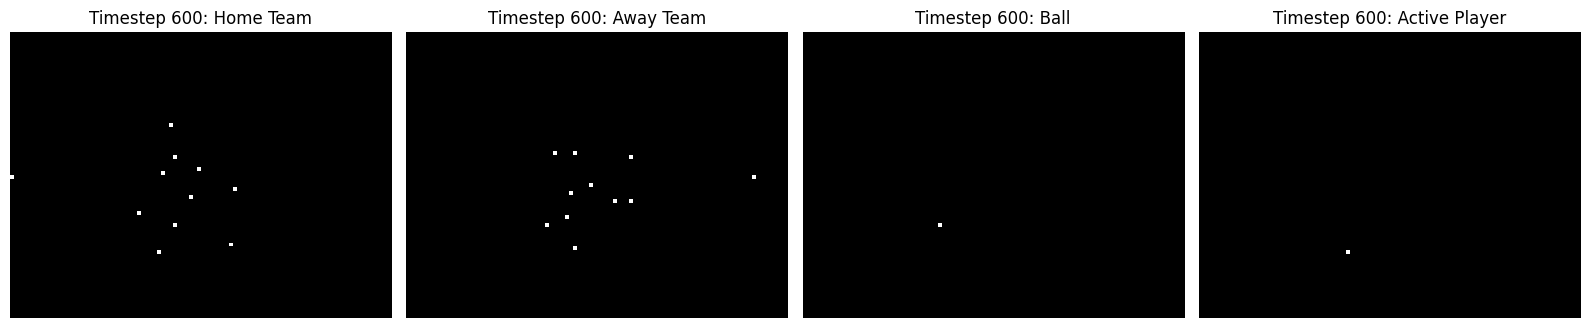

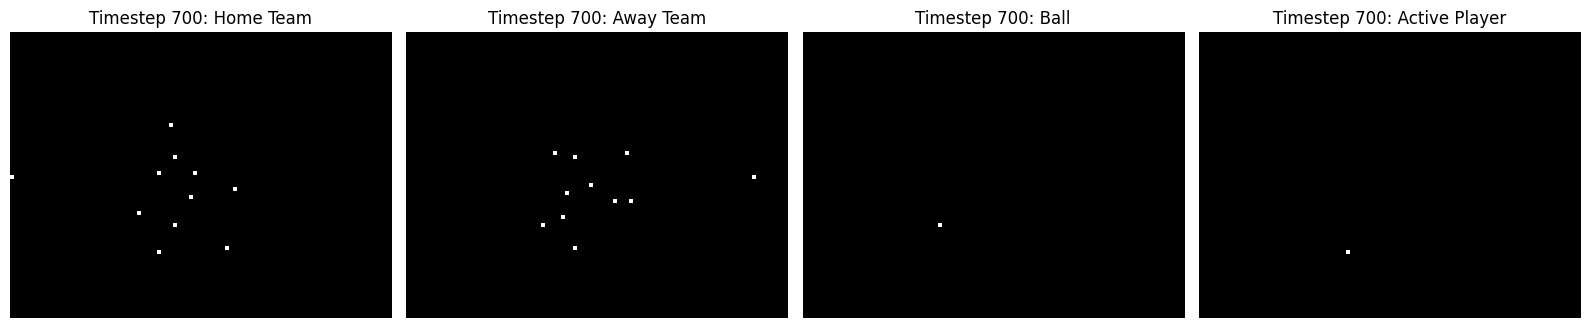

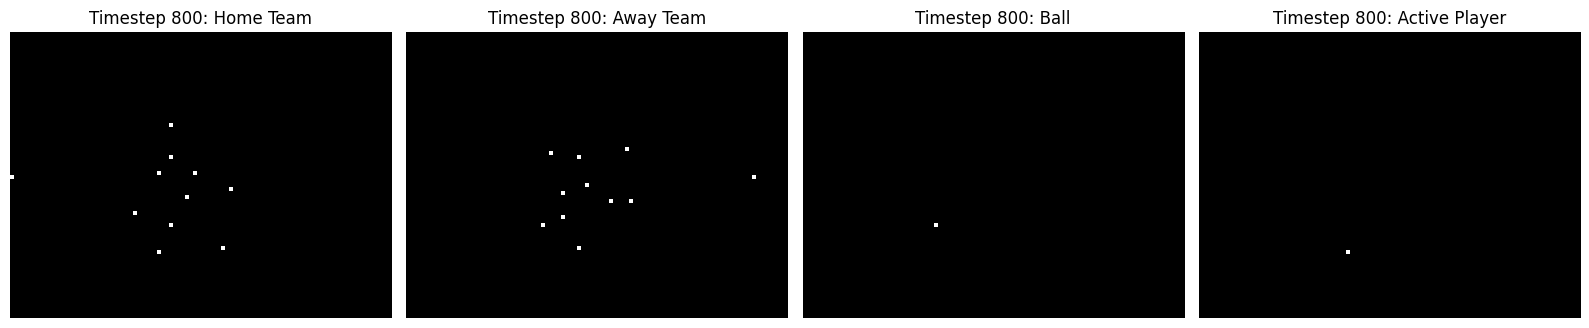

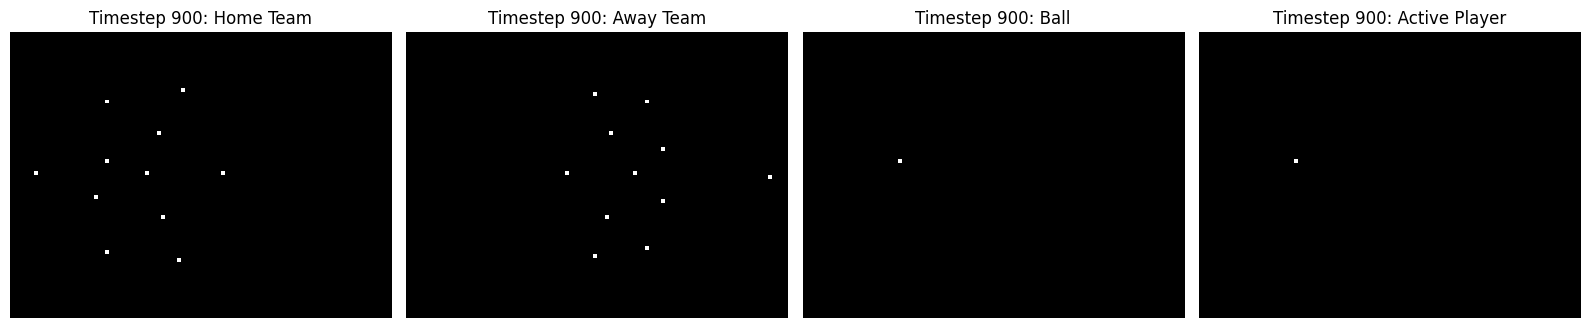

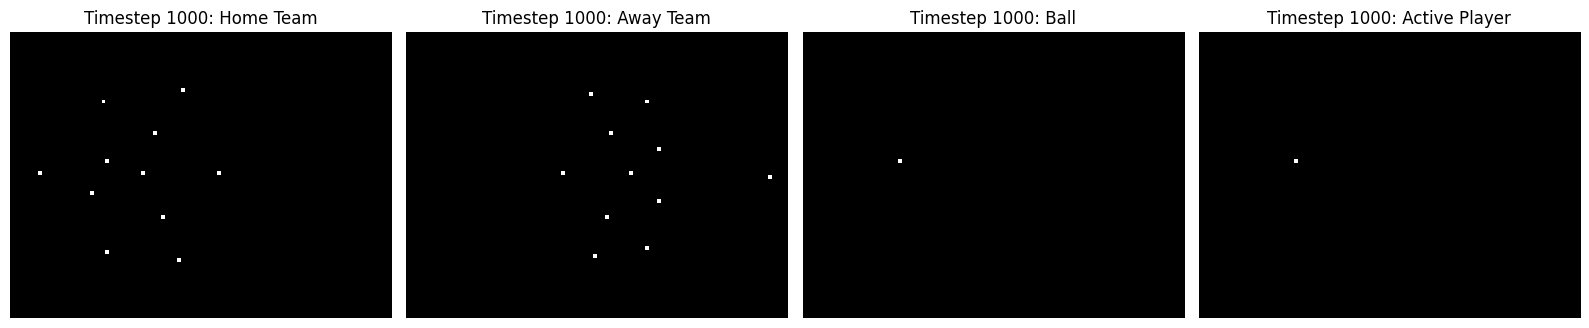

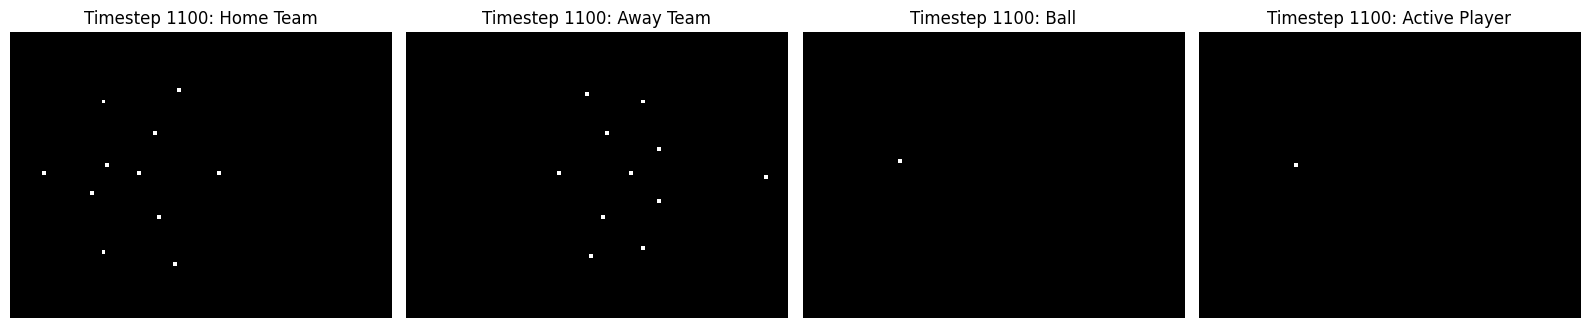

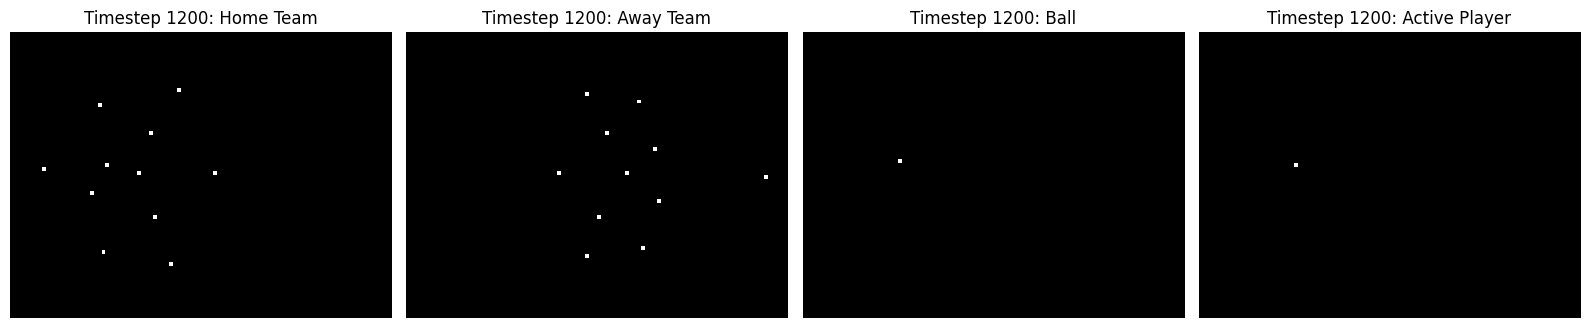

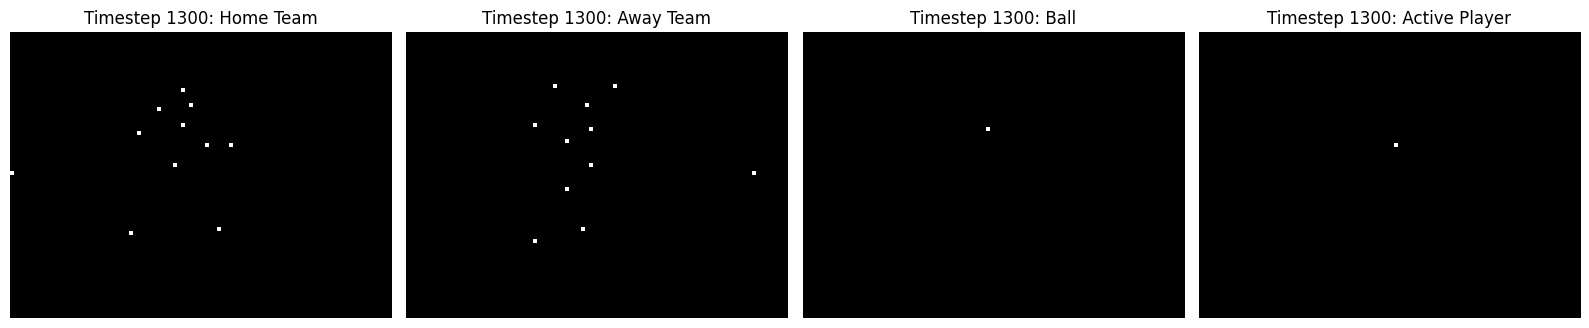

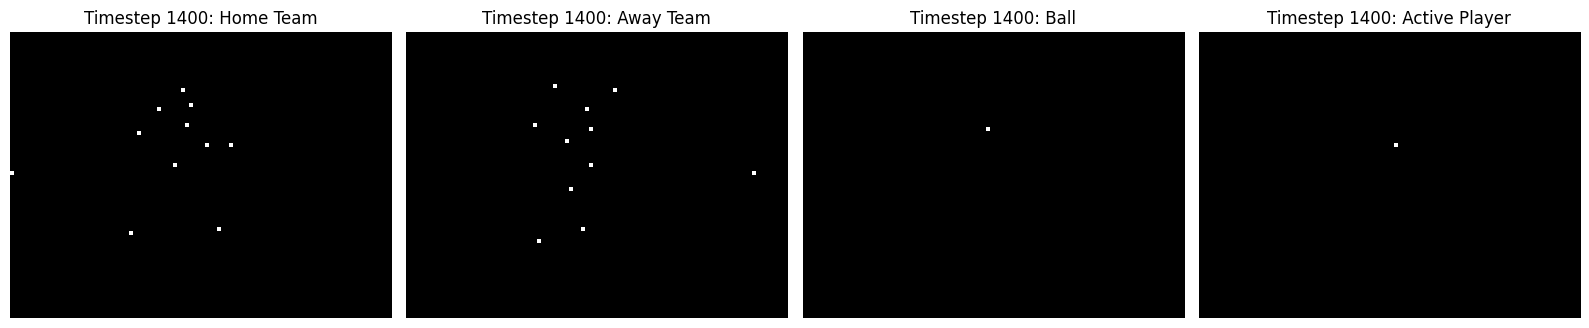

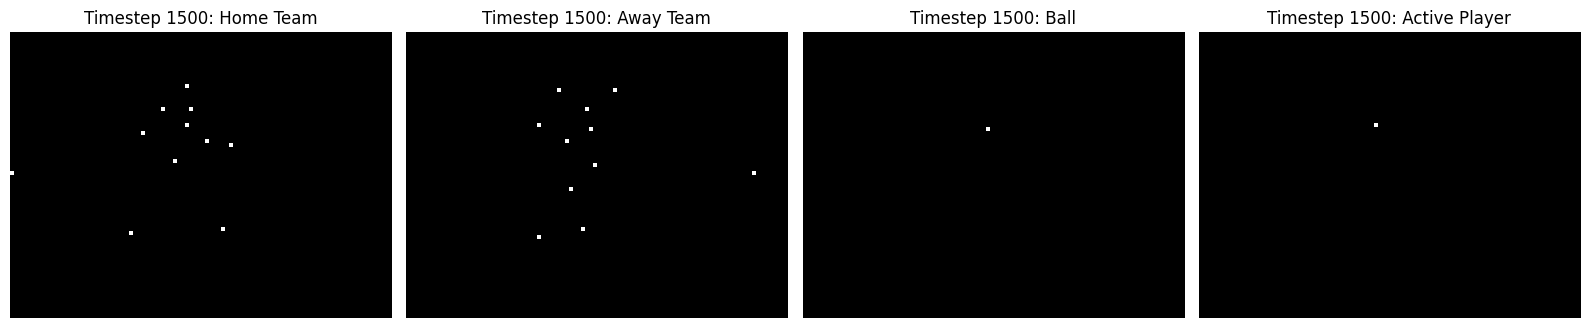

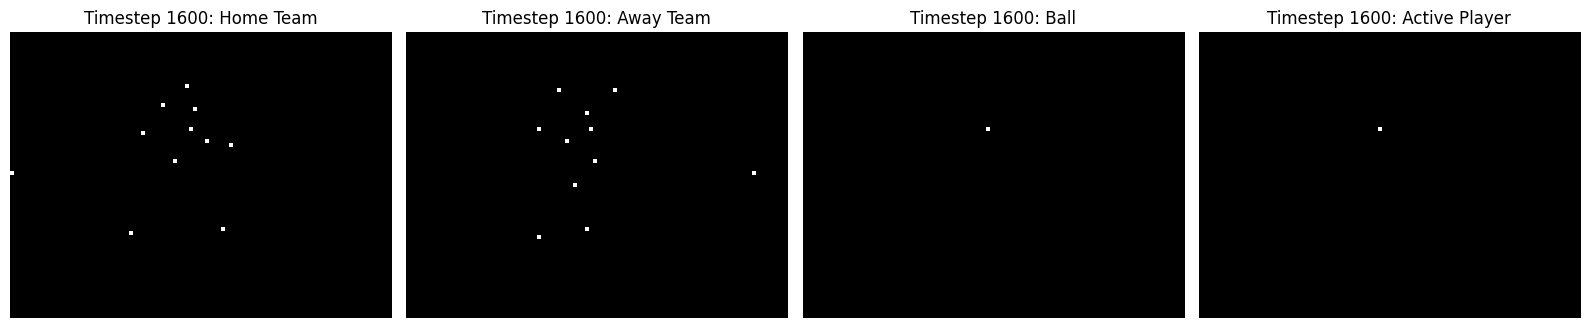

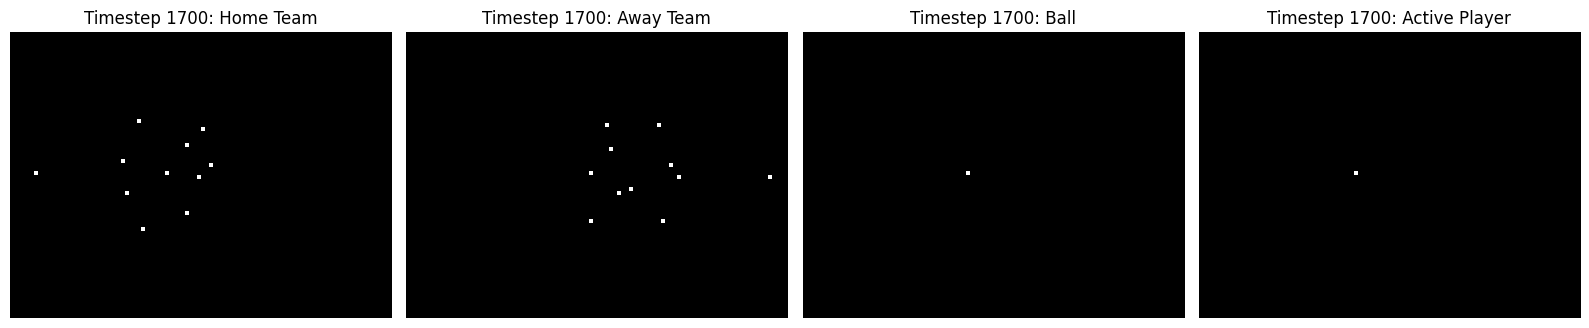

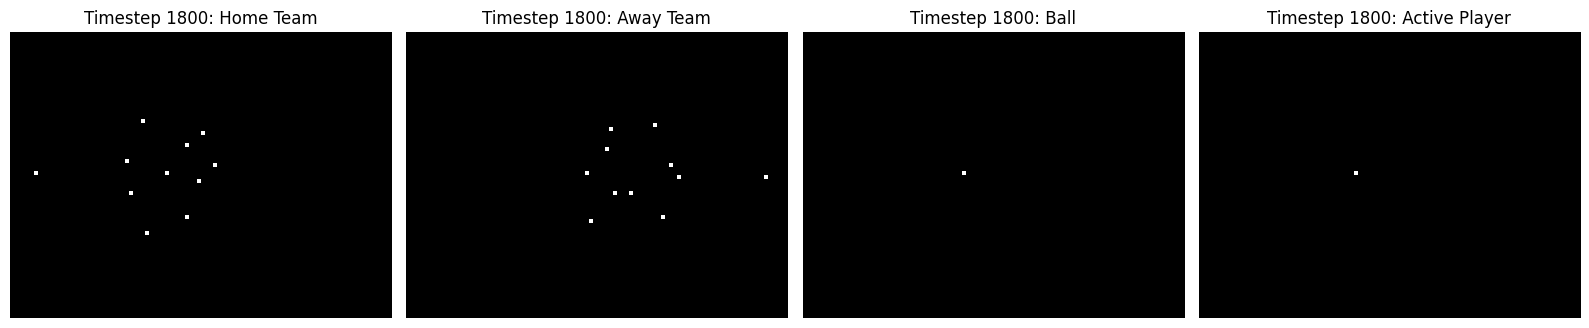

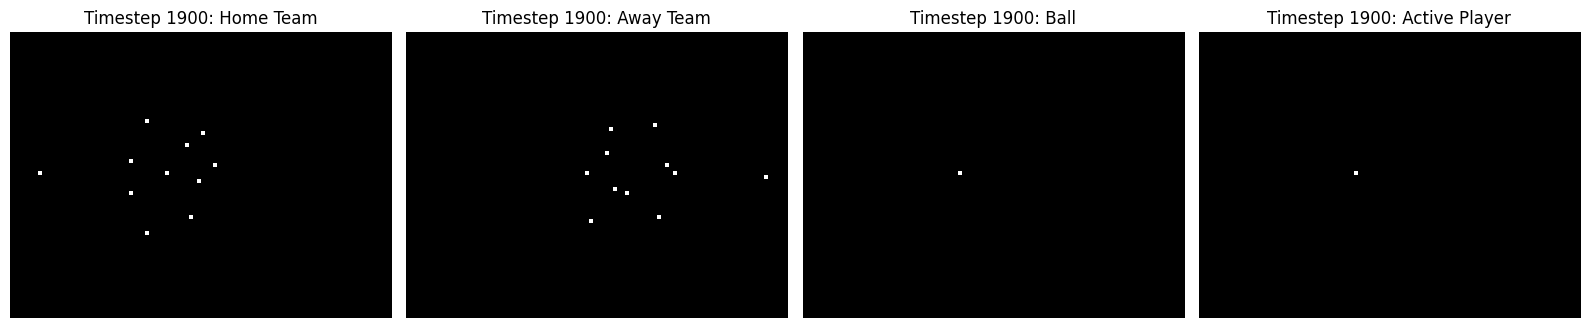

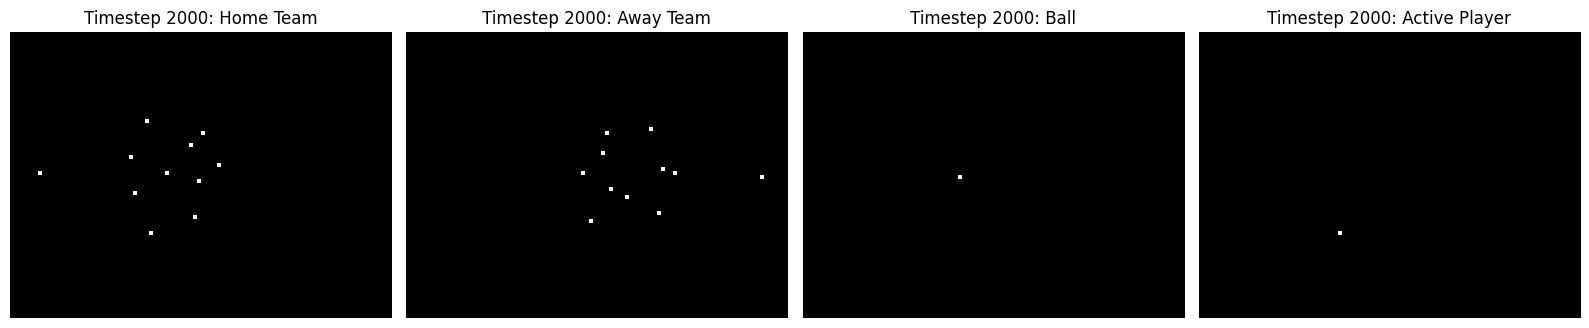

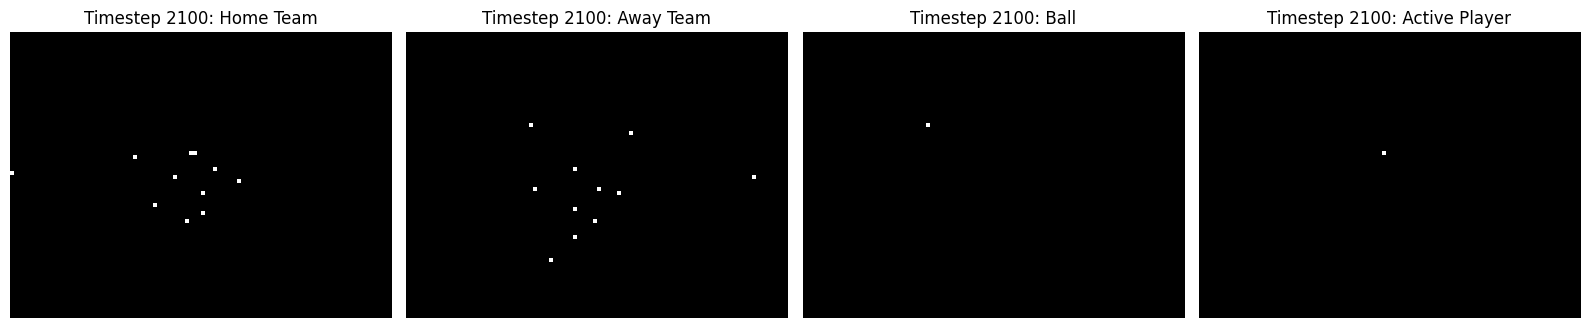

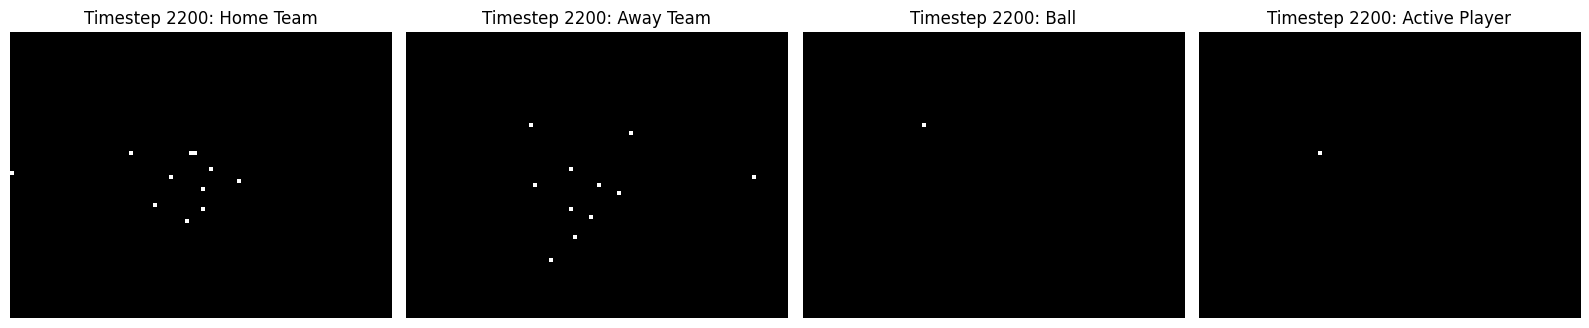

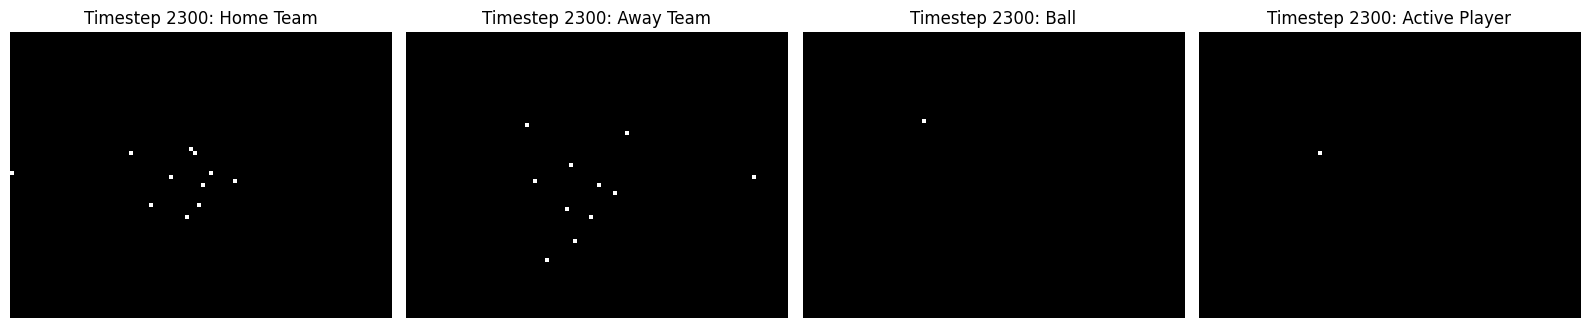

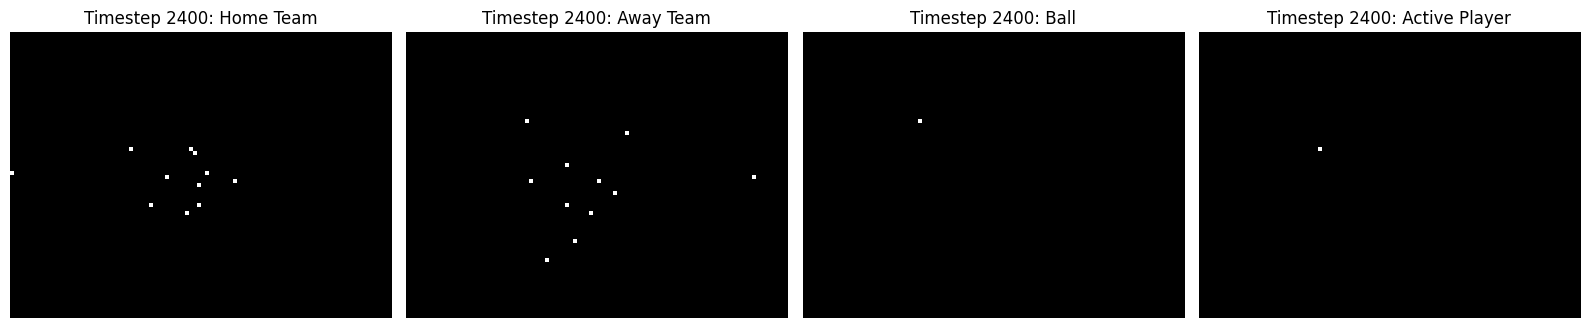

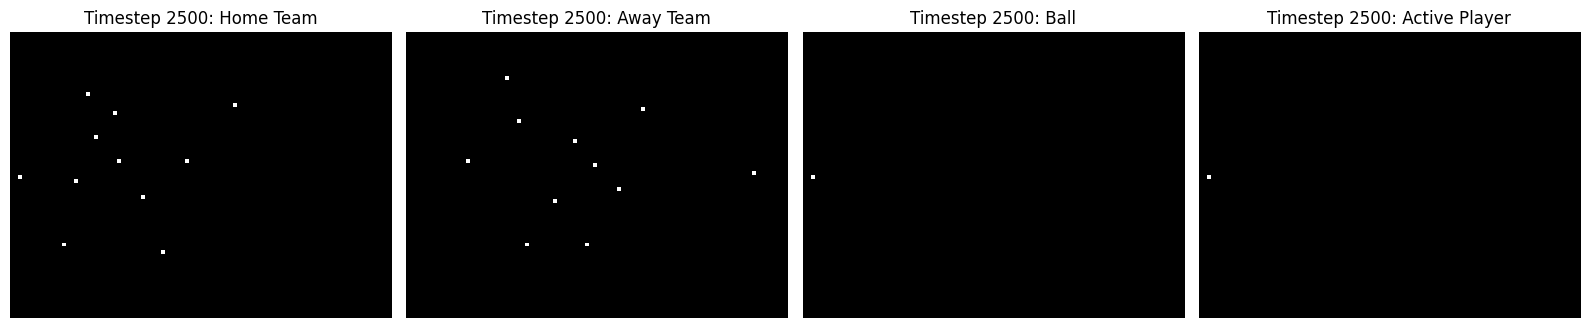

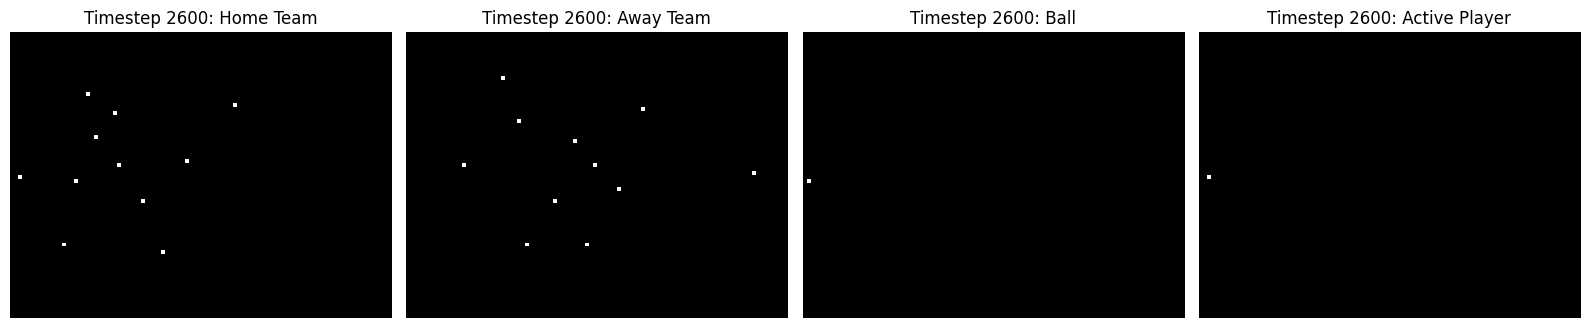

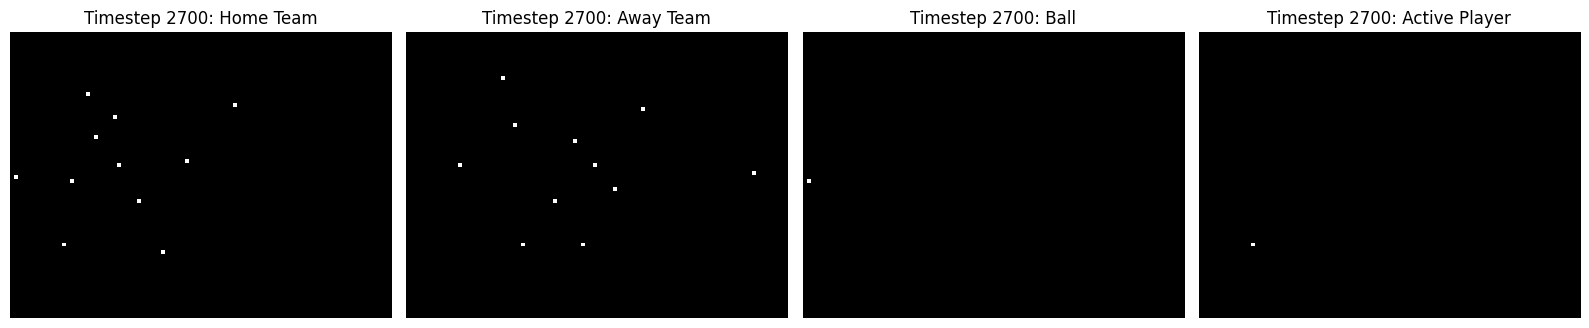

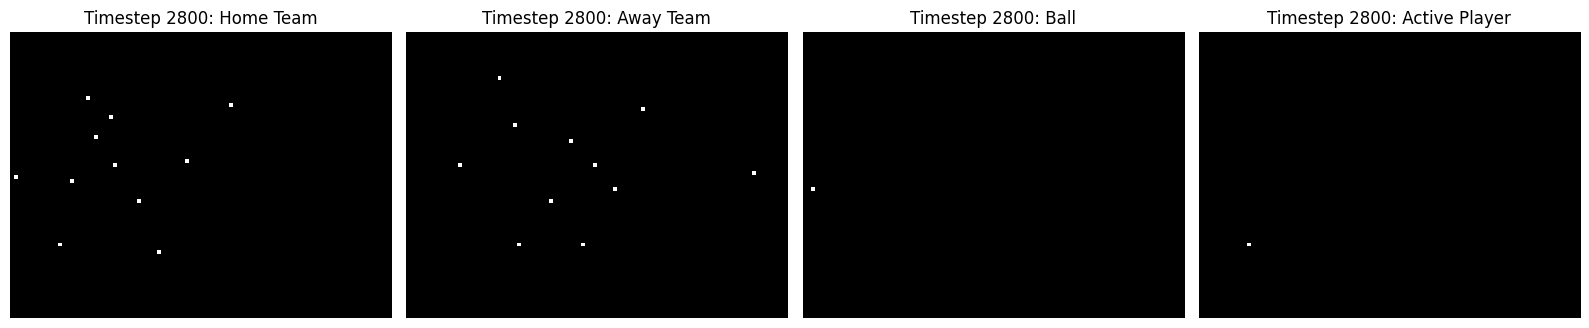

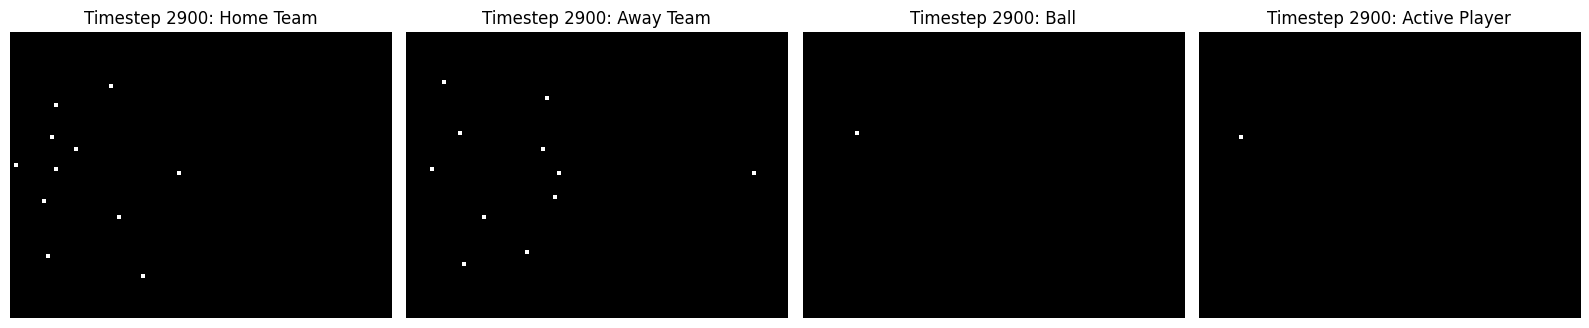

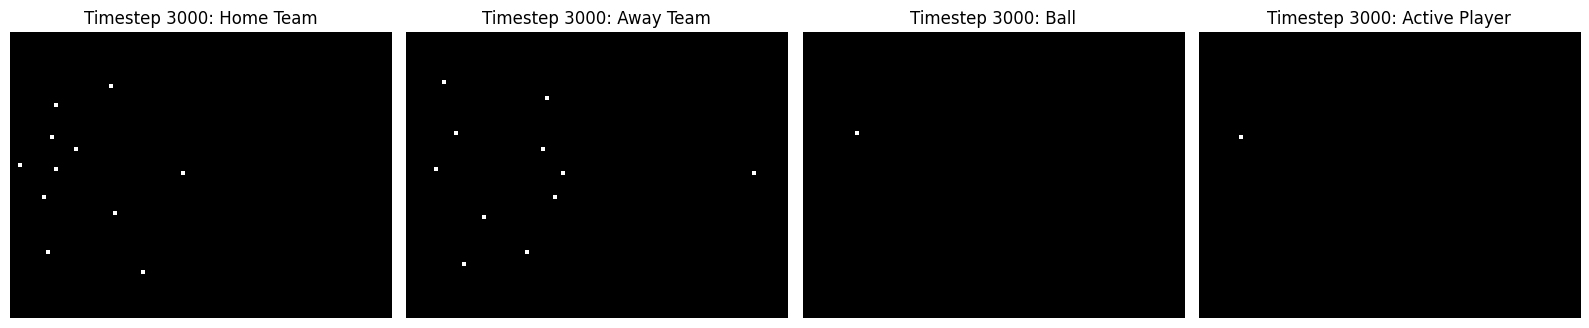

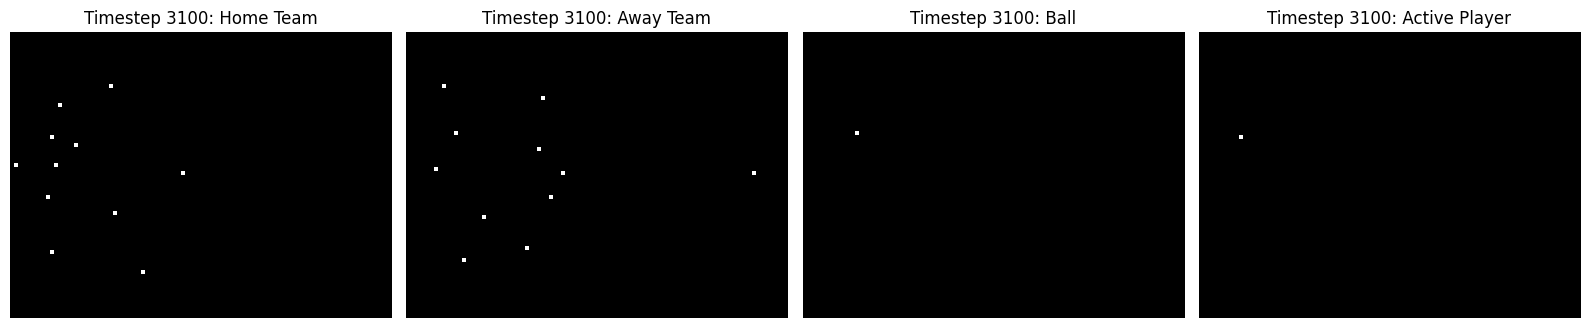

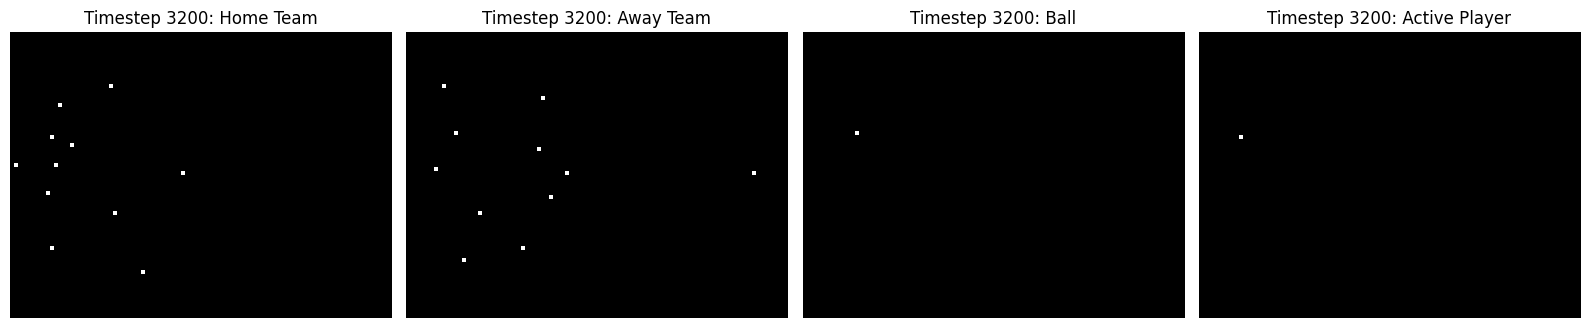

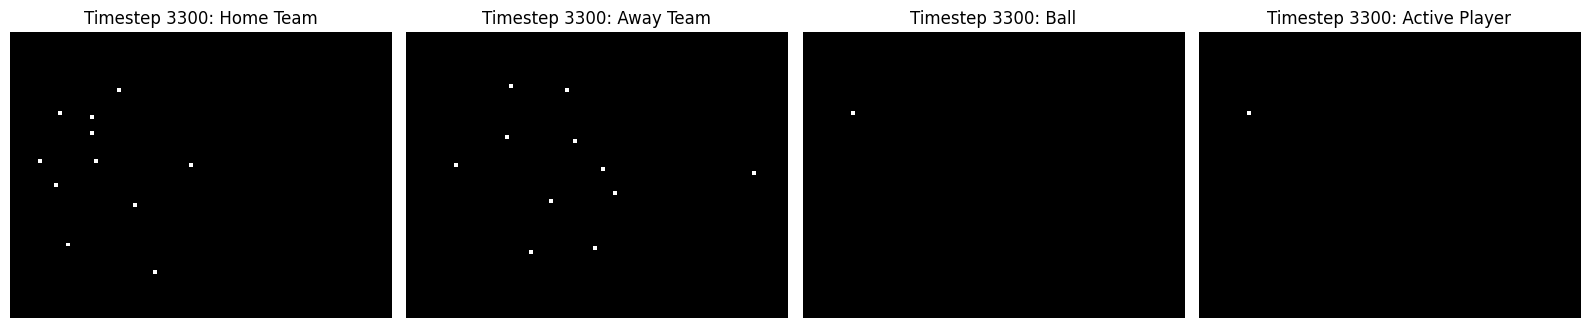

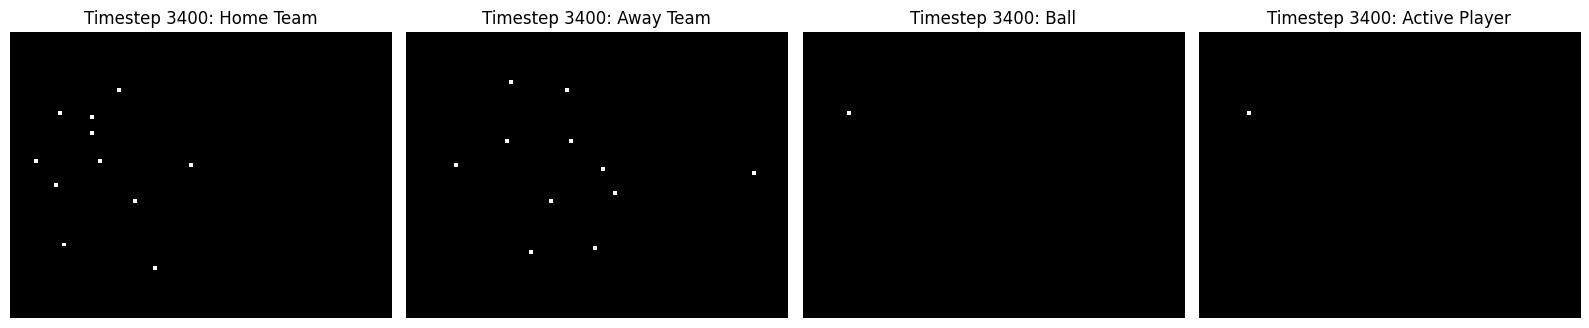

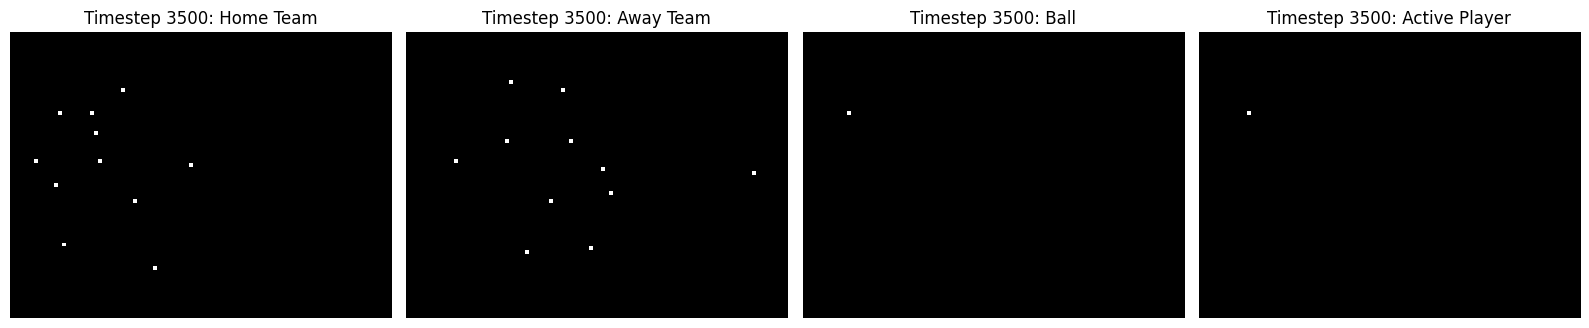

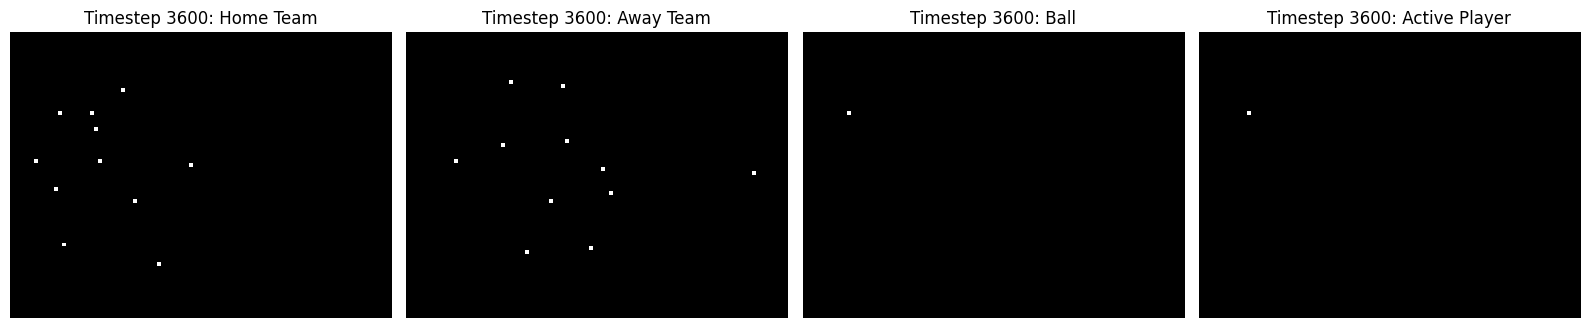

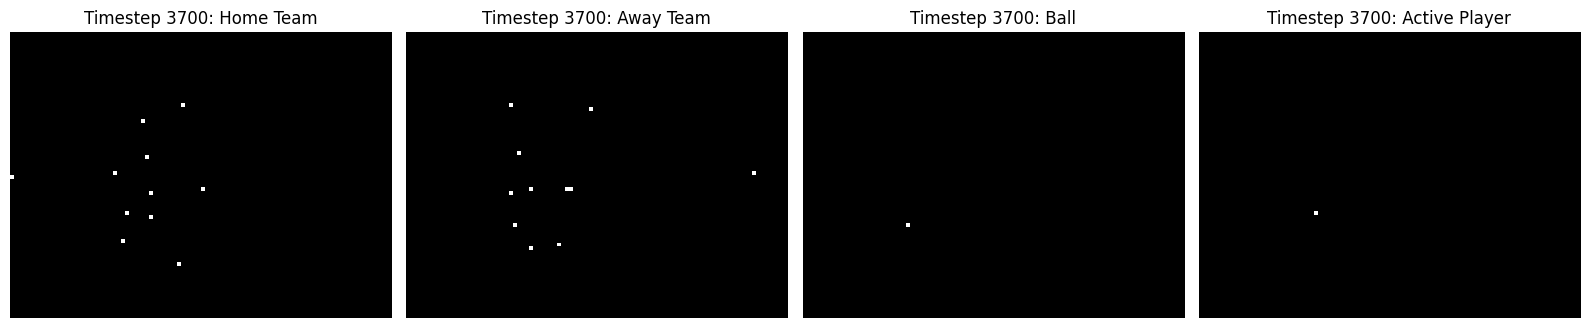

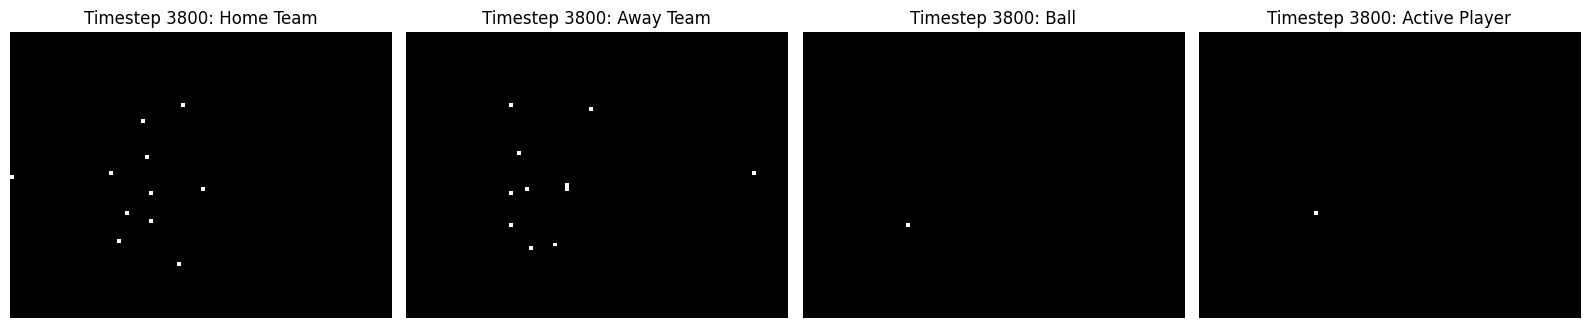

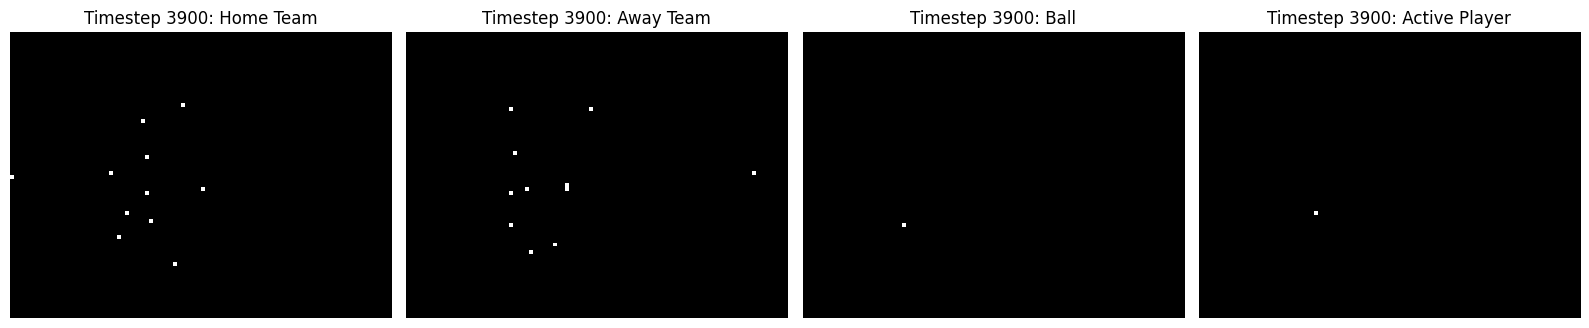

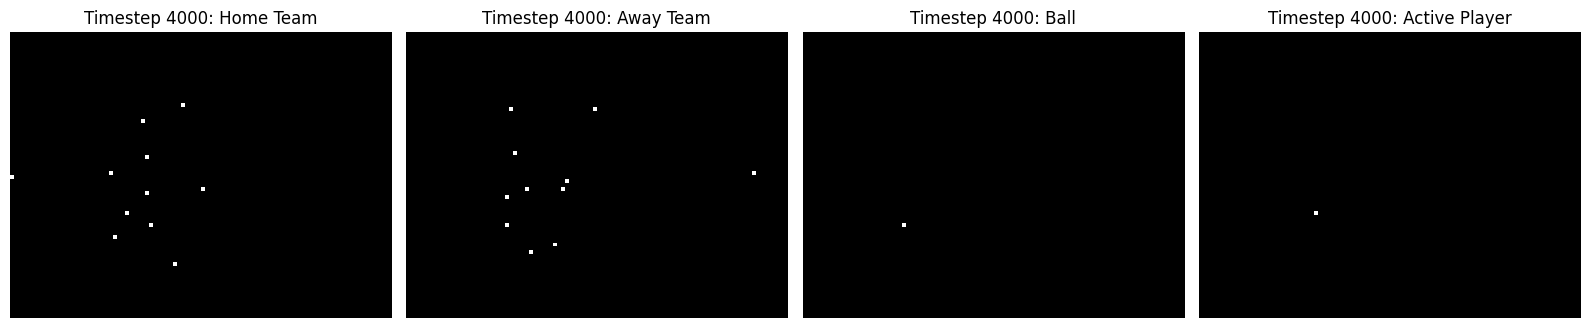

In [45]:

# 2) Reset and collect the first frame (t=0)
frames = []
obs = env.reset()  # obs.shape == (72, 96, 16)
frames.append(obs)

# 3) Step and collect every 10th stacked frame
for step in range(1000):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    print("action count:", step)

    if step % 100 == 0:
        # reshape from (72,96,16) → (H=72, W=96, stack=4, channels=4,)
        obs4 = obs.reshape(72, 96, 4, 4)

        # iterate over the 4 stacked frames
        for k in range(obs4.shape[2]):
            # obs4[k] has shape (72,96,4): (H, W, channels)

            frame = obs4[:, :, k, :]  # shape: (72, 96, 4)
            frames.append(frame)


    if done:
        break
# 4) Visualize
plane_names = ['Home Team', 'Away Team', 'Ball', 'Active Player']

for t, frame in enumerate(frames):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    for i, ax in enumerate(axes):
        ax.imshow(frame[:, :, i], cmap='gray', vmin=0, vmax=1)
        ax.set_title(f'Timestep {t*100}: {plane_names[i]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()